# Russian Layout Optimization with Bigrams

In [1]:
from lib import Corpus, Keyboard, Layout, Result, STANDARD_KBD, std_key_shape, STD_EXTRA_KEYS, ERGODOX, compare, BASE_KEYS_RU
import pandas as pd

# Contents

- [How this all works](#hiw)
- [How to test your layout](#how-to-test-your-layout)
- [Initialization and code](#init)
    - [Loading sample texts](#loading-texts)
        - [Some stats on bigrams](#some-stats)
    - [The code with the scoring rules](#scoring-code)
- [Comparing existing and my new layouts](#layouts)
- [Side-to-side comparisons of the best](#side-to-side)
- [Final standings](#standings)
- [Test your layout here](#your-layout)
    - [Compare with others](#compare)
    - [Output statistics in CSV](#output-statistics)
    - [Simple statistics of costs](#simple-stats)
    - [Where do letters want to move?](#letters-move)
- [Is Ergodox better?](#is-ergodox-better)
- [Heatmaps](#heatmaps)


## How This All Works <a name="hiw">

The code is organized in simple to use classes.
    
```
Corpus ------------------------------------------------> | Result
  .bigrams                                        /----> |   .score
                                                 /           .bigrams (w/ scores)
Keyboard ------------------>  Layout -----------/            .layout
  .keymap                       .keyboard                    .corpus
  (fingers & penalties)         .keymap
                                (keys w/ positions)
```

* `Corpus` stores bigrams dataframe, with frequencies and basic info about the letters for categorial analysis.
* `Keyboard` stores a dict: {(row, column): (finger, monogram penalty, ...)}
* To make a new Keyboard, provide it with fingers and penalties strings (see `STANDARD_KBD` and `ERGODOX` below).
* `Layout` takes keyboard, makes the dict a dataframe and adds keys to it.
* `Result` stores score and bigrams costs dataframes.
* `Result` can compare itself with another one, or better call `compare(results_dict, key1, key2)` to do things automatically.

## Testing Your Layout <a name="how-to-test-your-layout">

1. Run the cell with the code to make `CORP` and `STANDARD_KBD` (or another one).
1. Go to [Insert Your Layout](#your-layout) section.
2. Modify the layout, maintaining columns' positions, so that they match `STANDARD_KBD.fingers`.
3. Run the code & see the score.
4. Compare your layout to another one in the cells below that.

## Loading Sample Texts <a name="loading-texts">

This is a sample from Strugatski brothers' "Inhabited Island" and Michail Bulgakov's "White Guard", roughly 500K of characters. Compared to my own texts assembled in 300K chars, some letters differ slightly: letter И (i) is much less popular. I don't know what to do with this.

In [2]:
CORP = Corpus.from_path('../sampletexts.txt', 'sample1.txt', 'sample2.txt')

# Some stats on bigrams <a name="some-stats">

## Vowels outer or inner?

Negative = wants more to be on outer keys, positive = more to inner.

In [3]:
CORP.bigrams

bigram   num l1 l2 t1 t2      freq
0        ¶м   159  ¶  м  -  c  0.000174
1        мо  3241  м  о  c  v  0.003554
2        ож  1890  о  ж  v  c  0.002073
3        же  2825  ж  е  c  v  0.003098
4        ет  5188  е  т  v  c  0.005689
...     ...   ... .. .. .. ..       ...
2682     oн     1  o  н  -  c  0.000001
2683     нa     1  н  a  c  -  0.000001
2684     еp     1  е  p  v  -  0.000001
2685     yг     1  y  г  -  c  0.000001
2686     гy     1  г  y  c  -  0.000001

[2687 rows x 7 columns]

In [4]:
CORP.bigrams[(CORP.bigrams.t1 != '-') & (CORP.bigrams.t2 != '-')].groupby('l2').agg({'num': 'sum'}).sort_values('num', ascending=False)


num
l2       
о   71951
е   58480
а   54526
и   44490
т   42842
н   34441
р   30361
л   28373
с   26001
в   19409
к   17751
м   17189
д   16076
у   15812
ы   13770
ь   13741
я   12830
з    8539
й    8514
г    8425
б    7297
ч    7212
ж    5906
х    5796
п    5654
ю    4653
ш    4591
ц    2550
щ    2470
ё    1222
ф     938
ъ     273
э     268

freq_out     freq_in      outer   frequency     outerness
ъ    2.949778    0.000000  -2.949778    2.949778 -10000.000000
ь    9.902043    0.296074  -9.605969   10.198118  -9419.354839
ы   33.544131    2.434389 -31.109742   35.978520  -8646.754038
а   70.224457   19.332561 -50.891897   89.557018  -5682.625199
п  132.904501   41.625865 -91.278636  174.530366  -5229.957276
и   86.947177   37.436961 -49.510216  124.384138  -3980.428458
у   24.771557   12.040358 -12.731198   36.811915  -3458.445040
о   92.780939   88.405618  -4.375321  181.186556   -241.481571
э    1.184298    1.458440   0.274143    2.642738   1037.344398
е   50.014639  121.960714  71.946075  171.975353   4183.510808
я    6.382048   56.023853  49.641805   62.405900   7954.665261
ё    0.065794    2.938812   2.873018    3.004607   9562.043796
ю    0.515389   35.912726  35.397337   36.428115   9717.037929
й    1.030777   93.351156  92.320379   94.381934   9781.573138

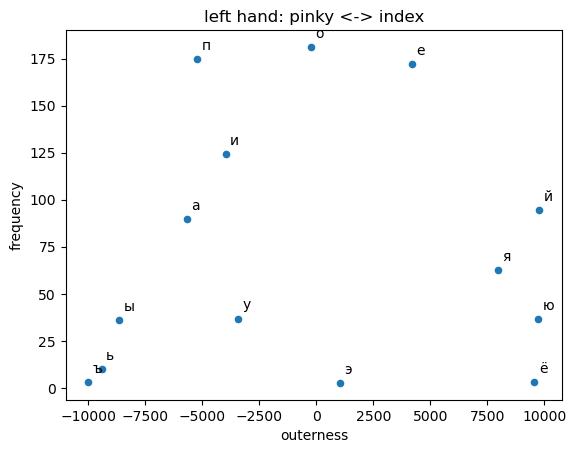

In [5]:
CORP.display_outerness("(t1 == 'v' | l1 == 'й' | l1 == 'п') & (t2 == 'v' | l2 == 'й' | l2 == 'п')", True)

## Consonants

In my layout, С (s) is the outermost (but in home column), Р (r) and Н (n) are innermost (in home column). Т comes too often before Р (-tr- is frequent like in English), so it isn't on the index finger.

freq_out     freq_in       outer   frequency    outerness
l1                                                             
щ     0.701806    5.044230   -4.342424    5.746036 -7557.251908
ц     1.173332    8.410706   -7.237374    9.584037 -7551.487414
л    21.503773   82.396404  -60.892631  103.900177 -5860.686016
р    51.900743  165.768757 -113.868014  217.669500 -5231.234257
н    62.559420  156.919423  -94.360002  219.478843 -4299.275543
т   103.461548  183.763500  -80.301952  287.225048 -2795.785133
к    43.413277   74.281773  -30.868496  117.695050 -2622.752259
м    21.624396   23.642088   -2.017692   45.266483  -445.736434
ф     2.620807    2.686601   -0.065794    5.307407  -123.966942
в    67.439165   61.660232    5.778933  129.099397   447.634418
ш    13.136930   10.176186    2.960744   23.313116  1269.990593
д    53.710086   40.200322   13.509764   93.910408  1438.580103
х     8.224288    5.680242    2.544047   13.904530  1829.652997
г    27.589746   11.963598   15.626148   39.553344  3950.651511
ж    21.942401    7.928214   14.014187   29.870615  4691.629956
с   241.541868   86.333097  155.208771  327.874964  4733.779264
ч    39.970042   11.042478   28.927564   51.012520  5670.679278
п    81.223072   21.536670   59.686402  102.759742  5808.344894
б    30.276347    5.680242   24.596105   35.956589  6840.500152
з    55.508464    4.210836   51.297628   59.719300  8589.790672
й    19.815052    0.010966   19.804086   19.826018  9988.938053

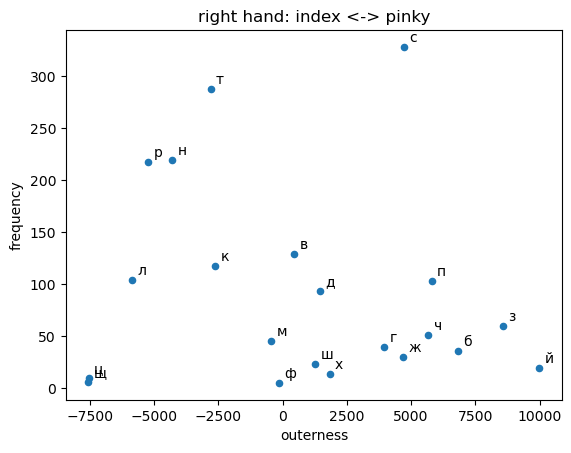

In [6]:
CORP.display_outerness("t1 == 'c' & t2 == 'c'")

Outputting the bigrams to Excel file, to see stats for each letter -- what letters come before it, and what ones come after.

In [7]:
BG = CORP.bigrams
dg2 = BG[BG.l1.isin(BASE_KEYS_RU) & BG.l2.isin(BASE_KEYS_RU)].copy()
dg2['kind_after'] = dg2.t2
dg2['dir'] = 'before'
dg2['kind_before'] = dg2.t1
dg2['letter_before'] = dg2.t1.isin(['v', 'c'])
dg2['letter_after'] = dg2.t2.isin(['v', 'c'])
pd1 = dg2.rename(columns={'l1': 'prev', 'l2': 'letter'}).pivot_table('num', 'letter', ['dir', 'kind_before', 'prev'], fill_value=0)
dg2['dir'] = 'after'
pd2 = dg2.rename(columns={'l2': 'next', 'l1': 'letter'}).pivot_table('num', 'letter', ['dir', 'kind_after', 'next'], fill_value=0)
dg3 = pd1.join(pd2)
dg3

dg3.melt(ignore_index=False).rename(
    columns={'variable_0': 'dir', 'variable_1': 'kind', 'variable_2': 'other', 'value': 'num'}
).reset_index().to_csv('all-letters-melt.csv')

# How Standard Keyboard is Really Used

In [42]:
real_kbd = Keyboard('real fingers', ''' 
000012 3678999
000123 66789999
 01233 6678999
 01233 667899
4
''', '''
987643 422389
864223 43124689
 21002 2001246
 42114 411224
0
''',
std_key_shape, STD_EXTRA_KEYS)

# Layouts <a name="layouts">

## Rules:

1. Spaces/linebreaks ARE SIGNIFICANT! (Except at the beginning and end of the whole string -- those are stripped.)
2. Two linebreaks = new level (Shift, AltGr), except for start and end of the whole string.
3. Rows must be in the same order.
4. Letters positions must match those in `FINGERS` and `POS_PENALTY` strings of th keyboard (`STANDARD_KBD` by default).
5. Backslash (`\`) requires Python's raw string syntax: `r''`. Otherwise, duplicate it -- but it creates a lot of confusion with positions.
6. `∅` means no letter at all (or same letter as in lower level). Currently, we don't compute penalties for Shift/AltGr.
7. `¶` means Enter key, and every linebreak in text is treated as hitting this key.
8. `⌴` means space. This is irrelevant for skewed keyboards (they get 0 for any digrams with space), but will be needed for Ergodox.
9. `→` means Tab. Tabs in the text are also scored as keypresses (although in literature corpus they're absent, but if we inserted any text with tables, we'd be able to account for the tab key).
    
## How to test Ergodox and other non-standard models
    
By default, these layouts are used with standard staggered keyboard. If you want Ergodox, then instead of 1 string provide a 2-tuple:
    
```python
    'my_layout': (r'''<the layout>''', ERGODOX),
```
    
If you want different key positions, make a different `Keyboard` instance:
    
```python
    'my_layout': (r'''<the layout>''', Keyboard(<fingers>, <penalties>)),
```
    
search for `леонов` (new finger positions in standard kbd) and `optozorax` (Ergodox) in the dictionary below for examples.

In [43]:
LEONOV_KBD = Keyboard("leonov's remapping", '''
0001233 667899
0001233 667899
 001233 667899
 001233 6678
4
''',

'''
8642226 622246
6421134 431124
 400002 200002
 211114 4111
0
''',
# '''
# 3211113 311123
# 2111112 211112
#  200001 100001
#  111112 2111
# 0
# ''',
#  '''
# 4322224 422234
# 3211123 321123
#  200002 200002
#  211113 3111
# 0
# ''',
         std_key_shape, STD_EXTRA_KEYS
)

In [48]:
layouts = {
    # standard Russian layout ~1890
    'йцукен': r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фывап ролджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
 ∅∅∅∅∅ ∅∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
''',

    # QWERTY transliterated ~1970
    'usphonetic': r'''
    
ю12345 67890-ь
→яверт ыуиопшщэ
 асдфг чйкл;'¶
 зхцжб нм,.%
⌴

∅!"ёЁъ Ъ?*()_∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅:"∅
 ∅∅∅∅∅ ∅∅<>?
''',

    # Dvorak transliterated ~2000
    'rusdvorak': r'''
    
ю12345 67890шщ
→',.пы фгцрл/чэ
 аоеуи дхтнс-¶
 ;яйкь бмвжз
⌴

∅!@ё∅ъ %&*()_∅
∅∅∅∅∅∅ ∅∅∅∅∅∅?∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 >:∅∅∅ ∅∅∅∅∅
''',

    # "Dictor" layout 200?
    'диктор': r'''
    
ё12345 67890-=
→цья,. звкдчшщ
 уиеоа лнтсрй¶
 фэхыю бмпгж
⌴

∅ъ"№;% :∅*()∅_+
∅∅∅∅?! ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 >:∅∅∅ ∅∅∅∅∅
''',

    # Zubachov's layout 2007
    'зубачёв': r'''
    
ё12345 67890-=
→фыаяъ ймрпхцщ
 гиеоу лтснзж¶
 шью.э бдвкч
⌴

∅!"№;% :\?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅,∅ ∅∅∅∅∅
''',

    # Skoropis 2014 (literally "Fastwrite") from https://cont.ws/@russkivek/93620
    # in fact, it's just a slightly Diktor with improved punctuation
    'скоропис': r'''
    
*.ёъ?! ∅-\'()∅
→цья,. звкдчшщ"
 уиеоа лнтсрй¶
 фэхыю бмпгж
⌴

%12345 67890∅∅
∅∅∅∅;: ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
''',

    # ANT layout 200?
    # this layout put Ъ's upper and lower case in different places,
    # which my code doesn't understand.
    # had to put the letter on one key to process
    'ант': r'''
    
\!?'"= +-*/%()
→гпрдм ыияухцжч
 внстл ьоеакз¶
 щйшб, .юэёф
⌴

_97531 02468""
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅; :∅∅∅∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ъ∅∅∅∅∅∅
 ∅∅∅∅; :∅∅∅∅
''',
    
    # UNGVS 2019 https://ubuntu-mate.community/t/make-your-own-custom-keyboard-layout-for-linux/19733/
    'ugnvs': r'''
    
`12345 67890-=
→пдмкз буяьыг:'
 аиеол внтср,¶
 щцэюф хчжйш
⌴

~!?/$% <>*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅;"
 ∅∅∅∅∅ ∅∅∅∅∅.∅
 ∅∅∅∅∅ ∅∅∅∅


∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅ъ∅∅∅∅
 ∅∅ё∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
''',
    
    # Leonov 2023 https://habr.com/ru/articles/717912/
    # author uses chords for comma and period, here instead they're put in 3rd layer on index fingers.
'леонов': # 
('''
∅123456 7890-=
→щцклбй ъыяэфш
 чзвнтд иаоес¶
 жхпрмг ёьую
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅.∅ ∅,∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''',
LEONOV_KBD),
'леонов2': # 
('''
∅123456 7890-=
→чгкблщ ёэыяфш
 цснтрд йиаое¶
 жзпмвх ъюуь
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅,∅ ∅.∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''', LEONOV_KBD),
'леонов3': # 
('''
ъ123456 7890-=
→щчклбй ёыяэфш
 цсвнтд иаоеп¶
 жзхрмг ьую,
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅.
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''', LEONOV_KBD),
    
    # my layouts 2021
    'тест1': r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фыоап рвлджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест2': r'''
    
ё12345 67890-=
→йцуюк енгбзхъ\
 ыоаия втсрпч¶
 элмдь жшщф.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест3': r'''

ё12345 67890-=
→ъцуюя ьнгбчхй\
 ыоаие втсрпз¶
 эфкмд жшщл.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест4': r'''
    
ё12345 67890-=
→ъэуюя цлнгчхй\
 оаыеи втсрпз¶
 фдьмк жшщб.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест5': r'''
    
ё12345 67890-=
→ъуьюя йлнгчцх\
 оаыеи втсрпз¶
 .фжэд мкшщб
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест6': r'''
    
/12345 67890-=
→ёъьую янвгчйцх
 оиаые лрптсз¶
 ,эфшщ кбмдж
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
   
    'тест7': r'''
    
/12345 67890-=
→ёъьую янджчйцх
 оиаые лрптсз¶
 ,эфшщ вбмкг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',

    'тест8': r'''
    
/12345 67890-=
→ёъыью янжкчзгх
 аоиуе лртпсд¶
 цэфшщ вмбй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    # 2021, the first tested on a real keyboard
  'тест9': r'''
    
/12345 67890-=
→ёъыью янжкчзгх
 аоиуе лртпсд¶
 цэфщш вмбй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    # my layouts below: 2024. #10 is the first after manual test
  'тест10': r'''
    
/12345 67890-=
→ёоюэф йнзкдчжц
 ауиея лртпбс¶
 ъыьшщ вмхг,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
  'тест11': r'''
    
/12345 67890-=
→ёоюяф лндкзчжц
 ауиеэ вртпбс¶
 ъыьшщ мхгй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
''',
  'тест12': r'''
    
/12345 67890-=
→ёуюяф лндкзчжц
 аоиеэ вртпбс¶
 ъыьшщ мхгй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест13': r'''
    
/12345 67890-=
→ёуюяф лндкзчжц
 аоиеэ вртпбс¶
 щыъьй мхгш,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест14': r'''
    
/12345 67890-=
→ёуюяф лндпзчжц
 аоиеэ вртксб¶
 щыъьй мхгш,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',

    'тест15': r'''
    
/12345 67890-=
→ёуюяф шндпзчжц
 аоиеэ вртксб¶
 щыъьй млхг,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест16': r'''    
/12345 67890-=
→ёуюяф шндгзчжц
 аоиеэ вртксб¶
 щыъьй млхп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    
'тест17': r'''    
/12345 67890-=
→ёуюяф шндмзчжц
 аоиеэ вртксб¶
 щыъьй хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест18': r'''    
/12345 67890-=
→ьуюяй шндмзчжц
 аоиеэ вртксб¶
 щыъёф хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест19': r'''    
/12345 67890-=
→ьуюяэ шндмвчжц
 аоией зртксб¶
 щыъёф хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест20': r'''    
/12345 67890-=
→ьуюяэ шнмдвчжц
 аоией гртксз¶
 щыъёф хлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест21': r'''    
/12345 67890-=
→ъыфхэ шнмдвчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест22': r'''    
/12345 67890-=
→ъыфхэ шнмдвчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест23': r'''    
/12345 67890-=
→ъыфхэ шнмвдчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест24': r'''    
/12345 67890-=
→ъыфхэ шнмвдзжц
 аоией гртксб¶
 ьуюяё щ.лпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅,∅∅∅
∅
''', 
'тест25': r'''    
/12345 67890-=
→ъыфхэ шнмвдзжц
 аоией гртксч¶
 ьуюяё щлпб.
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',
    # alien layout experiment #1, with rare letters Ё Щ Ъ on AltGr
    'ино1': r'''    
/12345 67890+
→:ыфхэ цнмвчзж
 аоией ,ртксд¶
 ьуюя- шлбпг
⌴

\!"№∅% ∅?*_()
∅;∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅= ∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅ё∅ ∅∅∅∅∅∅∅
 ъ∅∅∅∅ щ∅∅∅∅
∅
''',

    'тест26': r'''

ъ12345 67890-=
→щфыхё цнмвчзж/
 аоией ,ртксд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    'тест27': r'''

ъ12345 67890-=
→эыфх: цнмвчзжш
 аоией ,ртксд¶
 ьуюяё щлбпг
⌴

\!"№∅% ∅?*()_+
∅∅∅∅∅; ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
    # Alien layout #2, with voiced consonants on AltGr over their voiceless counterparts.
    # e.g. in English B<->P, T (mat) <-> D (mad), K (keel) <-> G (good), V <-> F,
    # Russian has more pairs.
    # same for vowels: compound vowels Я Ю Ё and rare Ё Э are on AltGr,
    # Ы is separated twin of И and also is put there
    
    # This scores great, but abuses the scoring system, because Shift & AltGr aren't penalized
    # In reality, it's hard to hit and release AltGr quickly
    'ино2': r'''

 12345 67890
→-()х: цнмфш+=
 аоией ,ртксч¶
 ьу я! щл п? 
⌴

\∅"№∅% ∅∅*∅∅∅∅
∅∅∅∅∅; ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅вж∅∅
 ∅ёыэ∅ ∅∅дгз∅∅
 ъю∅∅∅ ∅∅∅б∅
∅
''',
'тест28': r'''

ъ12345 67890-=
→щфыхё цмнвчзж/
 аоией ,ртксд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

    'тест29': r'''

ъ12345 67890-=
→щфыхё цмнкчзж/
 аоией ,ртвсд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
  'ино3': r'''

 12345 67890
→-()х: +кмфшщ=
 аоией ,ртнсч¶
 ьу  !  лп ? 
⌴

\∅"№∅% ∅∅*∅∅∅∅
∅∅∅∅∅; ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅г∅вж∅∅
 яёыэ∅ ∅д∅зц∅
 ъю∅∅∅ ∅∅∅б∅
∅
''',
    
'тест30': r'''

ъ12345 67890-=
→щфыхэ жвмкзгш/
 аоией ,ртнсд¶
 ьуюяё цлбпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест31': r'''

ъ12345 67890-=
→щфыхэ жмвкзгш/
 аоией ,ртнсд¶
 ьуюяё цлбпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест32': r'''

ъ12345 67890-=
→ьыхяё жшвкчзщ/
 аоией ,ртнсд¶
 пуфюэ цлмбг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест33': r'''

ъ12345 67890-=
→щфыхэ жмвкзчш/
 аоией ,ртнсд¶
 ьуюяё цлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест34': r'''

ъ12345 67890-=
→щфыхэ шмвкчзж/
 аоией ,ртнсд¶
 ьуюяё цлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
'тест35': r'''

ъ12345 67890-=
→чкдзг эхшыцьф/
 снтрм йеиоа,¶
 впблж ёяющу
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅.
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест36': r'''

ъ12345 67890-=
→щфыхэ цзмквчш/
 аиоей ,ртнсг¶
 ьуюяё жлдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест37': r'''
ъ12345 67890-=
→фцыхё шмвкзжэ
 аиое, йртнсч¶
 щьуяю глдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
'''
}

    

In [49]:
results = {}

for k, definition in layouts.items():
    if isinstance(definition, str):
        definition = (definition, real_kbd)
    lyt = Layout(k, definition)
    print(f'layout {k}: ', end='')
    results[k] = r = Result(CORP, lyt)
    print(round(r.score, 4))

layout йцукен: 3.2331
key """ repeated: 2
key "?" repeated: 2
layout usphonetic: 3.6617
layout rusdvorak: 2.2788
key ":" repeated: 2
layout диктор: 1.8585
layout зубачёв: 1.8349
key "." repeated: 2
layout скоропис: 1.8104
key """ repeated: 3
key ";" repeated: 2
key ":" repeated: 2
layout ант: 2.1368
layout ugnvs: 2.6043
layout леонов: 1.2334
layout леонов2: 1.0911
layout леонов3: 1.3106
layout тест1: 2.9587
layout тест2: 2.7825
layout тест3: 2.4815
layout тест4: 2.3548
layout тест5: 2.2107
layout тест6: 2.314
layout тест7: 2.3309
layout тест8: 2.2846
layout тест9: 2.293
layout тест10: 2.3272
layout тест11: 2.3278
layout тест12: 2.1268
layout тест13: 2.1426
layout тест14: 2.0798
layout тест15: 2.0066
layout тест16: 1.9994
layout тест17: 1.9683
layout тест18: 2.0327
layout тест19: 2.1026
layout тест20: 2.101
layout тест21: 2.0146
layout тест22: 2.0146
layout тест23: 1.982
layout тест24: 1.9337
layout тест25: 1.9757
layout ино1: 1.8441
layout тест26: 1.903
layout тест27: 1.9323
layout ино

# Final Standings <a name="standings">

In [50]:
print('Standard keyboard league:\n')
chosen_kbd = [
    ('йцукен', 'Default Russian kbd'),
    ('usphonetic', 'QWERTY transit'),
    ('rusdvorak', 'Dvorak translit'),
    ('диктор', 'Dictor'),
    ('зубачёв', 'Zubachov'),
    ('скоропис', 'Skoropis'),
    ('ант', 'ANT'),
    ('ugnvs', 'UGNVS'),
    ('леонов', 'Leonov'),
    ('тест1', 'Def.Rus with couple of letters swapped'),
    ('тест2', 'My first Dvorak analog'),
    ('тест9', 'First hand-tested'),
    ('тест10', 'First optimized after hand testing'),
    ('ино1', 'Alien #1, rare letters on AltGr'),
    ('тест37', 'Best and currently in use on my laptop'),
    ('ино2', 'Alien #2, many counterparts on AltGr'),
]
print(
    pd.DataFrame([(k, results[k].score.round(3), d) for k, d in chosen_kbd],
        columns=['layout', 'score', 'comment']).sort_values('score', ascending=True)
    .to_markdown(index=False)
)

# ergodox layouts moved to another notebook, see the folder

Standard keyboard league:

| layout     |   score | comment                                |
|:-----------|--------:|:---------------------------------------|
| леонов     |   1.233 | Leonov                                 |
| ино2       |   1.572 | Alien #2, many counterparts on AltGr   |
| тест37     |   1.762 | Best and currently in use on my laptop |
| скоропис   |   1.81  | Skoropis                               |
| зубачёв    |   1.835 | Zubachov                               |
| ино1       |   1.844 | Alien #1, rare letters on AltGr        |
| диктор     |   1.859 | Dictor                                 |
| ант        |   2.137 | ANT                                    |
| rusdvorak  |   2.279 | Dvorak translit                        |
| тест9      |   2.293 | First hand-tested                      |
| тест10     |   2.327 | First optimized after hand testing     |
| ugnvs      |   2.604 | UGNVS                                  |
| тест2      |   2.782 | My first Dvorak analog  

# Test Your Layout Here <a name="your-layout">
    
To measure this for a different keyboard, or different fingers positions, add Keyboard instance:
```python
'my_layout': (r'''
<layout definition>
''', Keyboard('my_special_kbd', ''' 
000012 3678999
000123 66789999
 01233 6678999
 01233 667899
4
''', '''
864222 4222468
622123 43112246
 00002 2000024
 11114 411112
0
'''))
```

To the results above: the Test27 layout seems very good, and I use it to type in Russian sometimes, but there's still some awkwardness to it. And it actually has much disbalance to the right hand. It's 20% more loaded and gets 80% more penalties.

IDK if I made something useful or just abuse my own scoring system.

тест37 : 1.762 


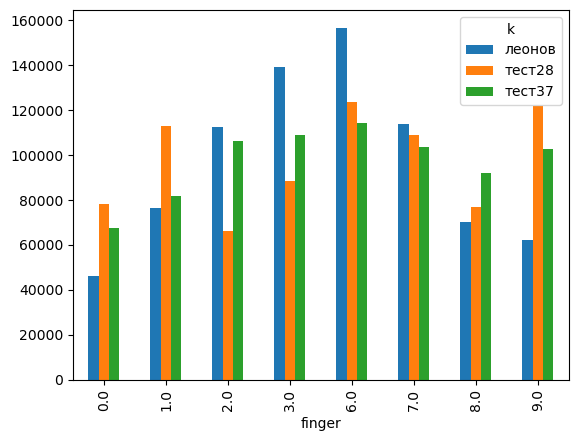

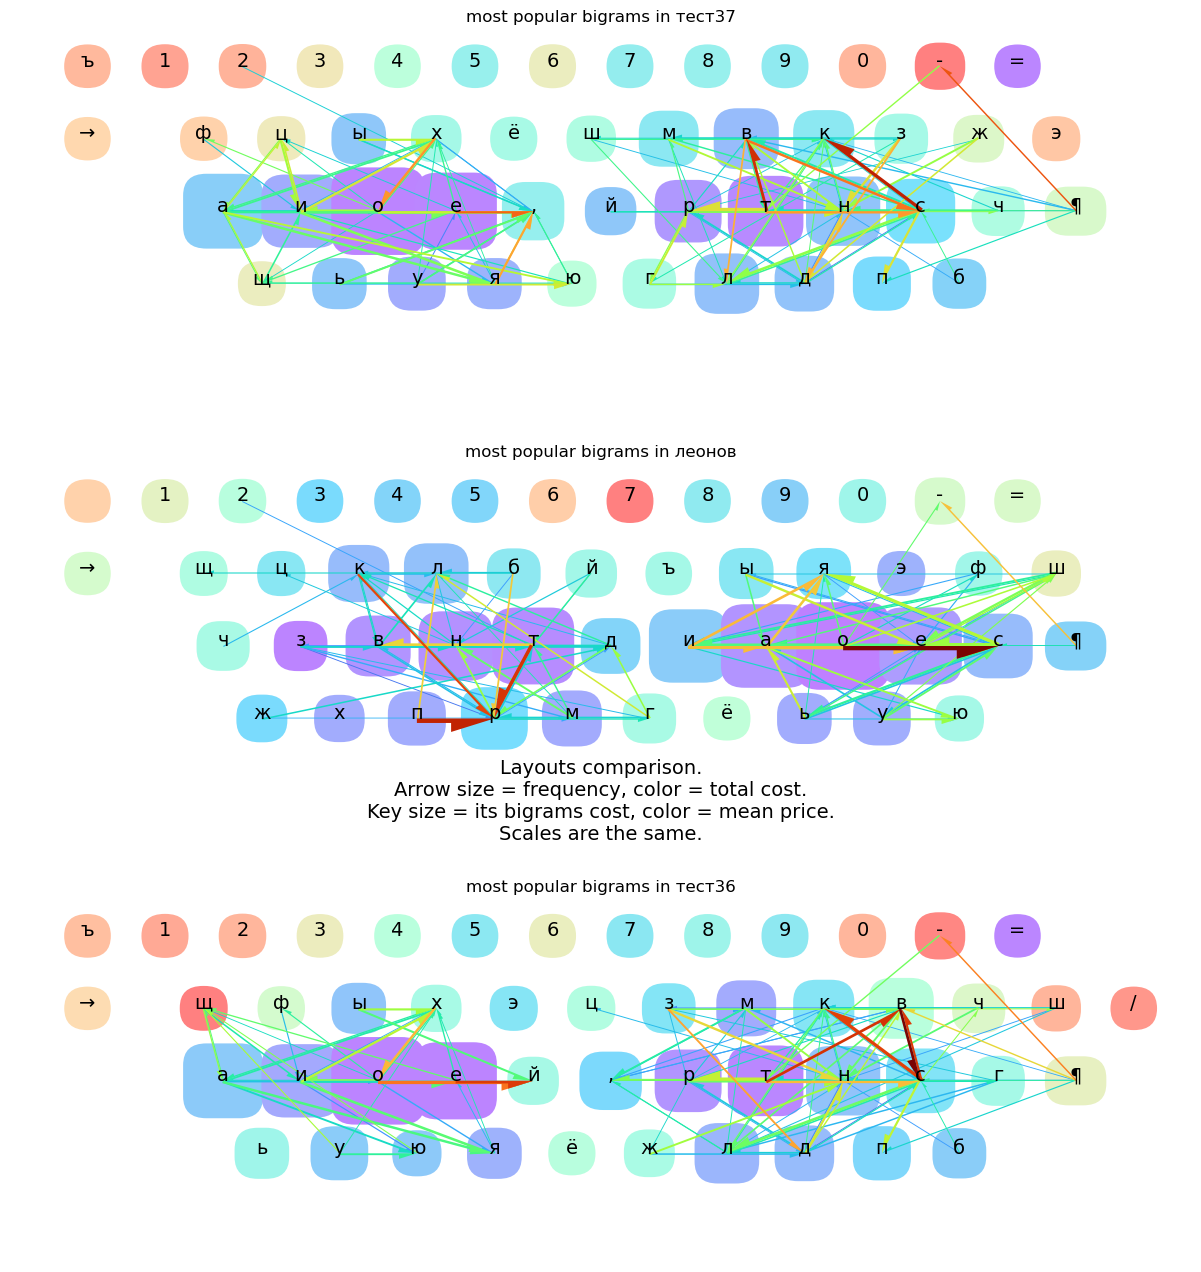

In [51]:
# →щфыхэ цзмквчш/
#  аиоей ,ртнсг¶
#  ьуюяё жлдпб

lyt = Layout('тест37', (r'''
ъ12345 67890-=
→фцыхё шмвкзжэ
 аиое, йртнсч¶
 щьуяю глдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''', real_kbd))


results[lyt.name] = r = Result(CORP, lyt)
print(lyt.name, ':', round(r.score, 3), '')

dfs = []
for k in ('тест28', 'тест37', 'леонов'):
    d = results[k].bigrams
    d = d[d.finger != 4].groupby('finger').agg({'num': 'sum'})
    d['k'] = k
    dfs.append(d)
pd.concat(dfs).pivot_table('num', 'k', 'finger').T.plot.bar()

results['тест37'].combomap(results['леонов'], results['тест36'])


In [52]:
results['тест37'].layout.export()


	default partial alphanumeric_keys
	xkb_symbols "v37" {
		include "ru(common)"
		name[Group1]= "Culebron (тест37)";
			key <TLDE> { [ Cyrillic_hardsign, Cyrillic_HARDSIGN, backslash ] };
	key <AE01> { [ 1, exclam ] };
	key <AE02> { [ 2, quotedbl ] };
	key <AE03> { [ 3, numerosign ] };
	key <AE04> { [ 4, semicolon ] };
	key <AE05> { [ 5, percent ] };
	key <AE06> { [ 6, colon ] };
	key <AE07> { [ 7, question ] };
	key <AE08> { [ 8, asterisk ] };
	key <AE09> { [ 9, parenleft ] };
	key <AE10> { [ 0, parenright ] };
	key <AE11> { [ minus, underscore ] };
	key <AE12> { [ equal, plus ] };
	key <AD01> { [ Cyrillic_ef, Cyrillic_EF ] };
	key <AD02> { [ Cyrillic_tse, Cyrillic_TSE ] };
	key <AD03> { [ Cyrillic_yeru, Cyrillic_YERU ] };
	key <AD04> { [ Cyrillic_ha, Cyrillic_HA ] };
	key <AD05> { [ Cyrillic_io, Cyrillic_IO ] };
	key <AD06> { [ Cyrillic_sha, Cyrillic_SHA ] };
	key <AD07> { [ Cyrillic_em, Cyrillic_EM ] };
	key <AD08> { [ Cyrillic_ve, Cyrillic_VE ] };
	key <AD09> { [ Cyrillic_ka, Cyril

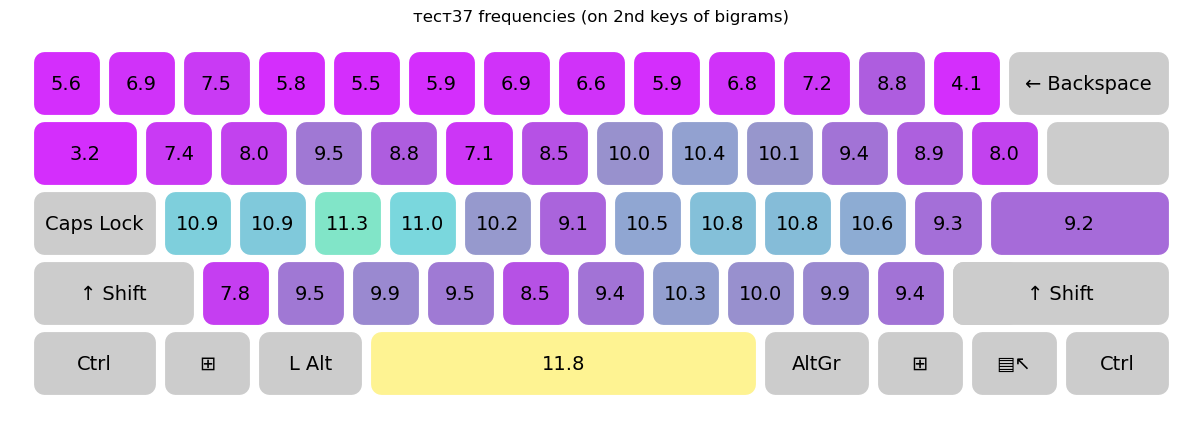

In [16]:
results['тест37'].display('num')

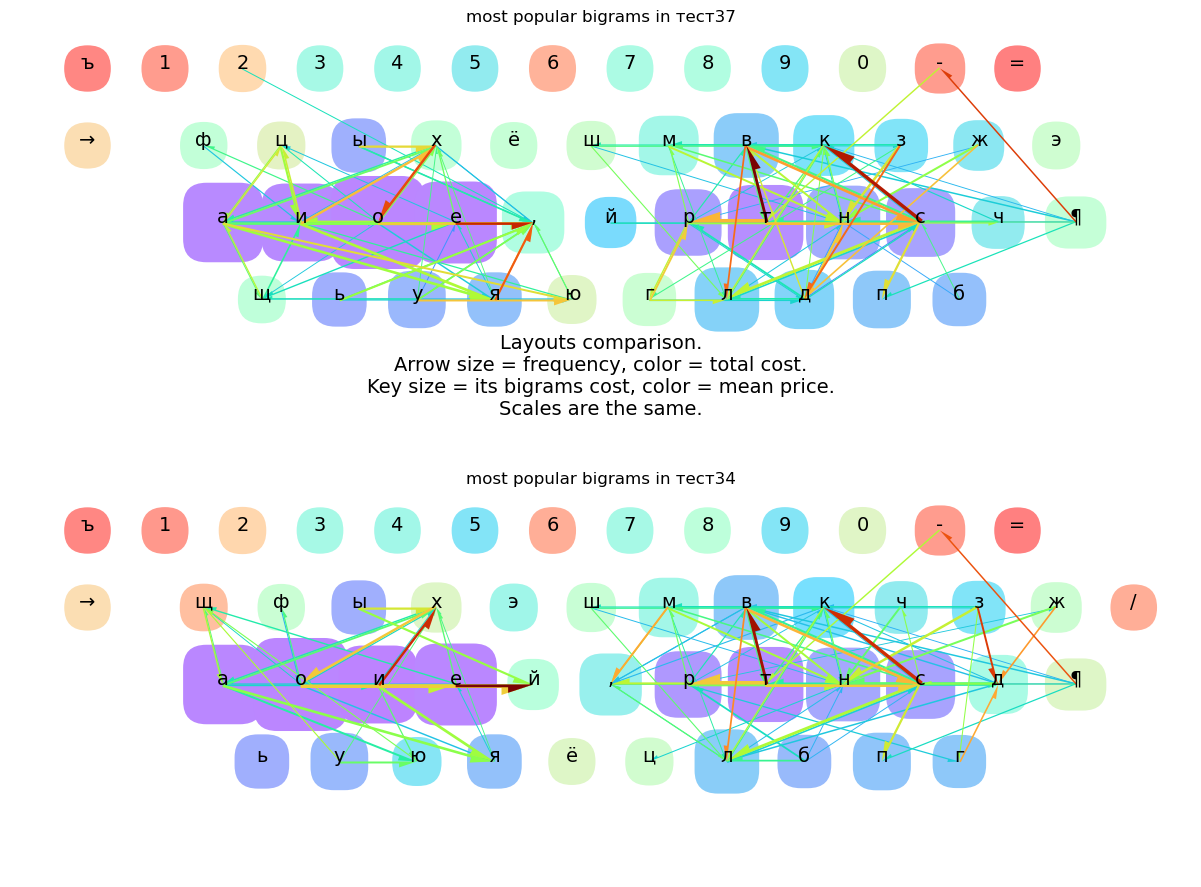

In [17]:
results['тест37'].combomap(results['тест34'])

In [18]:
results['тест34'].compare(results['тест37']).sort_values('delta', ascending=False).head(30)

bigram   num                     category_old  price_old  cost_old  \
153     ог  3341                     altern hands          1      3341   
79      ⌴г  3298                        space bar          1      3298   
272     е,  1459                     altern hands          2      2918   
132     я,  1162                     altern hands          2      2324   
332     ег  1977                     altern hands          1      1977   
365     е.   905                     altern hands          2      1810   
350     я.   806                     altern hands          2      1612   
259     гр   958       in, over 1 finger, adj row          1       958   
491     гл   645      in, over 1 finger, same row          1       645   
184     ое  1887      in, over 1 finger, same row          0         0   
412     дв   536       in, over 1 finger, adj row          2      1072   
231     ци  1184                     altern hands          0         0   
298     ца   345                     altern hands          0         0   
194     хо  1638             out, over one finger          4      6552   
289     ац   399                     altern hands          4      1596   
162     аю  1053       in, over 1 finger, adj row          2      2106   
378     ую  1019  in, adj finger, same or adj row          3      3057   
164     о,  1483                     altern hands          2      2966   
411     дн  1467  in, adj finger, same or adj row          2      2934   
82      рг   419                   index -> pinky          3      1257   
229     лю   960                     altern hands          1       960   
182     ⌴э  2440                        space bar          3      7320   
183     эт  2245                     altern hands          0         0   
140     уг   712                     altern hands          1       712   
425     ю,   346                     altern hands          2       692   
453     дк   279          pinky -> ring, next row          4      1116   
247     иц   647                     altern hands          4      2588   
257     ои   917  in, adj finger, same or adj row          2      1834   
287     аг   596                     altern hands          1       596   
738     йн   424                     altern hands          0         0   

                        category_new  price_new  cost_new  delta  
153                     altern hands          4     13364  10023  
79                         space bar          4     13192   9894  
272              same finger adj row          8     11672   8754  
132              same finger adj row          8      9296   6972  
332                     altern hands          4      7908   5931  
365              same finger adj row          8      7240   5430  
350              same finger adj row          8      6448   4836  
259              same finger adj row          6      5748   4790  
491              same finger adj row          7      4515   3870  
184  in, adj finger, same or adj row          2      3774   3774  
412             same finger over row          9      4824   3752  
231          pinky -> ring, next row          3      3552   3552  
298                    pinky adj row         10      3450   3450  
194              same finger adj row          6      9828   3276  
289                    pinky adj row         12      4788   3192  
162       in, over 1 finger, adj row          5      5265   3159  
378  in, adj finger, same or adj row          6      6114   3057  
164  in, adj finger, same or adj row          4      5932   2966  
411             out, over one finger          4      5868   2934  
82               same finger adj row         10      4190   2933  
229                     altern hands          4      3840   2880  
182                        space bar          4      9760   2440  
183       in, over 1 finger, adj row          1      2245   2245  
140                     altern hands          4      2848   2136  
425              same finger adj r

## Compare with others <a name="compare">

See what has changed, what bigrams degraded, and what were benefitial.

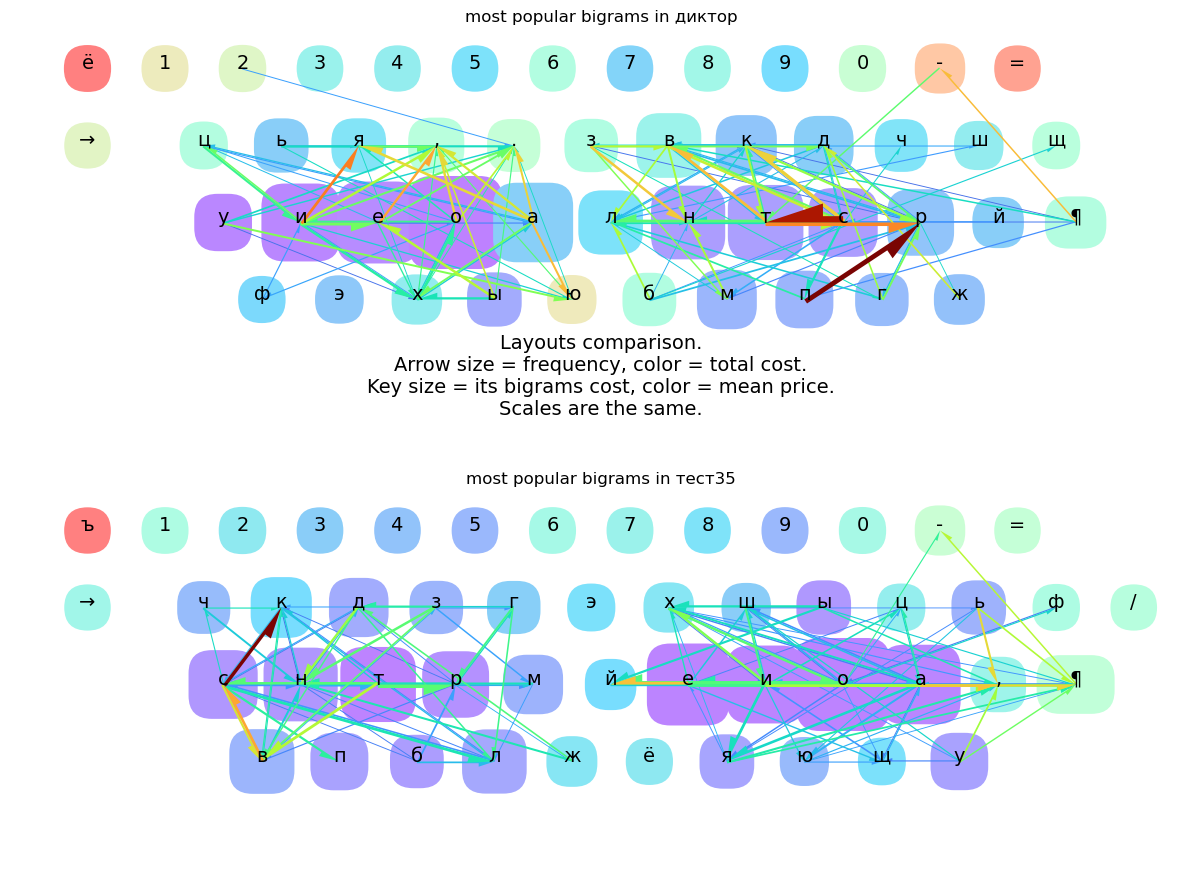

In [19]:
results['диктор'].combomap(results['тест35'])

## Losses

In [20]:
compare(results, 'тест32', 'тест33').head(30)

bigram   num                     category_old  price_old  cost_old  \
25      ⌴м  5232                        space bar          1      5232   
191     ом  4114                     altern hands          1      4114   
102     ем  3307                     altern hands          1      3307   
41      пр  6010                     altern hands          0         0   
106     им  2603                     altern hands          1      2603   
299     ам  2406                     altern hands          1      2406   
111     их  1574             out, over one finger          5      7870   
916     ща   415                     altern hands          0         0   
302     сп  1291                     altern hands          1      1291   
192     м,   964  in, adj finger, same or adj row          4      3856   
331     ущ   350                     altern hands          4      1400   
424     м.   538  in, adj finger, same or adj row          4      2152   
435     ию   408                    in, lower row          2       816   
378     ую  1019      in, over 1 finger, same row          1      1019   
379     ющ   332                     altern hands          4      1328   
239     ым   975                     altern hands          1       975   
792     ащ   235                     altern hands          4       940   
973     оф   373                    in, lower row          2       746   
362     ум   866                     altern hands          1       866   
346     бл   789      in, over 1 finger, same row          1       789   
473     ях   212             out, over one finger          5      1060   
794     мл   234  in, adj finger, same or adj row          3       702   
146     рм   345             out, over one finger          5      1725   
71      ых  1340  in, adj finger, same or adj row          3      4020   
381     см   638       in, over 1 finger, adj row          2      1276   
223     мп   159                     altern hands          1       159   
408     чш   113      in, over 1 finger, same row          3       339   
701     аф   122       in, over 1 finger, adj row          2       244   
260     сш   121       in, over 1 finger, adj row          4       484   
351     вп   120                     altern hands          1       120   

                        category_new  price_new  cost_new  delta  
25                         space bar          3     15696  10464  
191                     altern hands          3     12342   8228  
102                     altern hands          3      9921   6614  
41        in, over 1 finger, adj row          1      6010   6010  
106                     altern hands          3      7809   5206  
299                     altern hands          3      7218   4812  
111              same finger adj row          8     12592   4722  
916                    pinky adj row         10      4150   4150  
302          pinky -> ring, next row          4      5164   3873  
192              same finger adj row          8      7712   3856  
331              adj finger over row         12      4200   2800  
424              same finger adj row          8      4304   2152  
435              same finger adj row          7      2856   2040  
378  in, adj finger, same or adj row          3      3057   2038  
379        over 1 finger, over 1 row         10      3320   1992  
239                     altern hands          3      2925   1950  
792                    pinky adj row         12      2820   1880  
973          ring -> pinky, next row          7      2611   1865  
362                     altern hands          3      2598   1732  
346  in, adj finger, same or adj row          3      2367   1578  
473              adj finger over row         12      2544   1484  
794             same finger over row          9      2106   1404  
146              same finger adj row          9      3105   1380  
71   in, adj finger, same or adj row          4      5360   1340  
381       in, over 1 finger, adj r

## Gains

In [21]:
compare(results, 'тест32', 'тест33').tail(30)

bigram   num                     category_old  price_old  cost_old  \
316     ох   389              same finger adj row          7      2723   
426     ью   299        pinky -> index over 1 row          5      1495   
422     еп   602                   index -> pinky          3      1806   
285     шл   321             same finger over row          9      2889   
70      ры  1324                     altern hands          2      2648   
436     пу   664  in, adj finger, same or adj row          3      1992   
606     пя   152        over 1 finger, over 1 row         10      1520   
339     ля  1397                     altern hands          2      2794   
276     сь  1534                     altern hands          2      3068   
923     яю   181              adj finger over row         11      1991   
224     пе  1713       in, over 1 finger, adj row          1      1713   
265     фи   356              same finger adj row          6      2136   
277     ая  1782       in, over 1 finger, adj row          3      5346   
112     вы  2043                     altern hands          2      4086   
205     бы  2274                     altern hands          2      4548   
182     ⌴э  2440                        space bar          4      9760   
159     уп   711             out, over one finger          5      3555   
445     пы   219                   pinky over row         14      3066   
131     ся  3016                     altern hands          2      6032   
194     хо  1638              same finger adj row          6      9828   
498     зм   567        over 1 finger, over 1 row          9      5103   
236     ны  3979                     altern hands          2      7958   
188     бщ   337              adj finger over row         14      4718   
46      ль  4283                     altern hands          2      8566   
38      ть  5581                     altern hands          2     11162   
295     оп  1156          ring -> pinky, next row          6      6936   
291     ап   735                    pinky adj row         11      8085   
303     па  1120                    pinky adj row         10     11200   
262     ия  1949              same finger adj row          8     15592   
55      по  7093          pinky -> ring, next row          3     21279   

                        category_new  price_new  cost_new  delta  
316  in, adj finger, same or adj row          4      1556  -1167  
426      in, over 1 finger, same row          1       299  -1196  
422                     altern hands          1       602  -1204  
285        pinky -> index over 1 row          5      1605  -1284  
70                      altern hands          1      1324  -1324  
436                     altern hands          1       664  -1328  
606                     altern hands          1       152  -1368  
339                     altern hands          1      1397  -1397  
276                     altern hands          1      1534  -1534  
923           index->middle same row          2       362  -1629  
224                     altern hands          0         0  -1713  
265       in, over 1 finger, adj row          1       356  -1780  
277       in, over 1 finger, adj row          2      3564  -1782  
112                     altern hands          1      2043  -2043  
205                     altern hands          1      2274  -2274  
182                        space bar          3      7320  -2440  
159                     altern hands          1       711  -2844  
445                     altern hands          1       219  -2847  
131                     altern hands          1      3016  -3016  
194             out, over one finger          4      6552  -3276  
498      in, over 1 finger, same row          3      1701  -3402  
236                     altern hands          1      3979  -3979  
188                     altern hands          2       674  -4044  
46                      altern hands          1      4283  -4283  
38                      altern han

You can save the comparison table to CSV:

In [22]:
compare(results, 'леонов', 'тест33').to_csv('leonov-test33.csv')

## Simple Statistics, What Cost The Most <a name="simple-stats">

In [23]:
results['тест33'].bigrams.sort_values('cost', ascending=False).head(30) #.to_csv('/tmp/test26.csv')

bigram    num l1 l2 t1 t2      freq  price_l2  price_di  \
177     .¶   3921  .  ¶  -  -  0.004300         4         2   
53      ¶¶   4802  ¶  ¶  -  -  0.005266         4         0   
296     ей   2009  е  й  v  c  0.002203         2         6   
25      ⌴м   5232  ⌴  м  -  c  0.005737         3         0   
49      тв   2081  т  в  c  c  0.002282         1         6   
124     ⌴-   2268  ⌴  -  -  -  0.002487         6         0   
40      ⌴п  13192  ⌴  п  -  c  0.014466         1         0   
111     их   1574  и  х  v  c  0.001726         2         6   
125     --   2097  -  -  -  -  0.002300         6         0   
114     ск   3125  с  к  c  c  0.003427         1         3   
191     ом   4114  о  м  v  c  0.004511         3         0   
447     зд    979  з  д  c  c  0.001074         2        10   
227     ⌴д   5792  ⌴  д  -  c  0.006351         2         0   
18      ⌴в  11347  ⌴  в  -  c  0.012443         1         0   
802     ¶-    586  ¶  -  -  -  0.000643         6        12   
102     ем   3307  е  м  v  c  0.003626         3         0   
195     од   4816  о  д  v  c  0.005281         2         0   
338     вл    794  в  л  c  c  0.000871         1        10   
106     им   2603  и  м  v  c  0.002854         3         0   
301     гд    645  г  д  c  c  0.000707         2        10   
192     м,    964  м  ,  c  -  0.001057         2         6   
133     ⌴ч   3827  ⌴  ч  -  c  0.004197         2         0   
2       ож   1890  о  ж  v  c  0.002073         4         0   
465     вс   1832  в  с  c  c  0.002009         0         4   
182     ⌴э   2440  ⌴  э  -  v  0.002676         3         0   
299     ам   2406  а  м  v  c  0.002638         3         0   
94      ⌴з   3466  ⌴  з  -  c  0.003801         2         0   
30      ⌴к   6687  ⌴  к  -  c  0.007333         1         0   
35      ов   6667  о  в  v  c  0.007311         1         0   
254     ⌴ж   1645  ⌴  ж  -  c  0.001804         4         0   

                    category  price   cost  finger  column  row  
177           index -> pinky      6  23526     9.0    13.0  2.0  
53                  same key      4  19208     9.0    13.0  2.0  
296      same finger adj row      8  16072     3.0     5.0  2.0  
25                 space bar      3  15696     6.0     8.0  1.0  
49       same finger adj row      7  14567     7.0     9.0  1.0  
124                space bar      6  13608     9.0    12.0  0.0  
40                 space bar      1  13192     8.0    10.0  3.0  
111      same finger adj row      8  12592     2.0     4.0  1.0  
125                 same key      6  12582     9.0    12.0  0.0  
114  pinky -> ring, next row      4  12500     8.0    10.0  1.0  
191             altern hands      3  12342     6.0     8.0  1.0  
447            pinky adj row     12  11748     9.0    12.0  2.0  
227                space bar      2  11584     9.0    12.0  2.0  
18                 space bar      1  11347     7.0     9.0  1.0  
802           pinky over row     18  10548     9.0    12.0  0.0  
102             altern hands      3   9921     6.0     8.0  1.0  
195             altern hands      2   9632     9.0    12.0  2.0  
338      adj finger over row     11   8734     6.0     8.0  3.0  
106             altern hands      3   7809     6.0     8.0  1.0  
301            pinky adj row     12   7740     9.0    12.0  2.0  
192      same finger adj row      8   7712     6.0     7.0  2.0  
133                space bar      2   7654     9.0    12.0  1.0  
2               altern hands      4   7560     6.0     7.0  1.0  
465     out, over one finger      4   7328     9.0    11.0  2.0  
182                space bar      3   7320     3.0     5.0  1.0  
299             altern hands      3   7218     6.0     8.0  1.0  
94                 space bar      2   6932     9.0    11.0  1.0  
30                 space bar      1   6687     8.0    10.0  1.0  
35              altern hands      1   6667     7.0     9.0  1.0  
254                space bar      4   6580     6.0     7.0  1.0

## Statistics of Bigrams to CSV <a name="output-statistics">

We count how often a key comes before or after which one. We add categories to simplify statistics analysis: vowel/consonant/other, hand (in layout 27), row, column. 

In [24]:
key = 'тест33' # the output file will be 'all-letters-melt-<key>.csv'
res = results[key]


BG = CORP.bigrams
km = res.layout.keymap
dg2 = BG[BG.l1.isin(BASE_KEYS_RU) & BG.l2.isin(BASE_KEYS_RU)].copy()
dg2['kind_after'] = dg2.t2
dg2['row1'] = dg2.l1.map(km['row'])
dg2['row2'] = dg2.l2.map(km['row'])
dg2['hand1'] = dg2.l1.map(km['hand']).map({0: 'left', 1: 'right'})
dg2['hand2'] = dg2.l2.map(km['hand']).map({0: 'left', 1: 'right'})
dg2['dir'] = 'before'
dg2['kind_before'] = dg2.t1
dg2['letter_before'] = dg2.t1.isin(['v', 'c'])
dg2['hand'] = dg2.hand1
dg2['row'] = dg2.row1
dg2['letter_after'] = dg2.t2.isin(['v', 'c'])
pd1 = dg2.rename(columns={'l1': 'prev', 'l2': 'letter'}
        ).pivot_table('num', 'letter', ['dir', 'kind_before', 'hand', 'row', 'prev'], fill_value=0)

dg2['dir'] = 'after'
dg2['hand'] = dg2.hand2
dg2['row'] = dg2.row2

pd2 = dg2.rename(columns={'l2': 'next', 'l1': 'letter'}
                ).pivot_table('num', 'letter', ['dir', 'kind_after', 'hand', 'row', 'next'], fill_value=0)
dg3 = pd1.join(pd2) #.reset_index()

dg3.melt(ignore_index=False).reset_index().rename(
    columns={'variable_0': 'where', 'variable_1': 'ftype', 'variable_4': 'other', 
             'variable_2': 'hand', 'variable_3': 'row', 'value': 'num',
            'letter': 'letter'}).to_csv(f'all-letters-melt-{key}.csv')

## Check the keymap (for errors) <a name="keymap">

In [25]:
lyt.keymap
# or 
# results['тест28'][1]

layer  row  column  key_count  finger  ftype  hand  penalty
ъ      0    0       0          1       0      4     0        8
1      0    0       1          1       0      4     0        6
2      0    0       2          1       0      4     0        4
3      0    0       3          1       0      4     0        2
4      0    0       4          1       1      3     0        2
5      0    0       5          1       2      2     0        2
6      0    0       7          1       3      1     0        4
7      0    0       8          1       6      1     1        2
8      0    0       9          1       7      2     1        2
9      0    0      10          1       8      3     1        2
0      0    0      11          1       9      4     1        4
-      0    0      12          1       9      4     1        6
=      0    0      13          1       9      4     1        8
→      0    1       0          1       0      4     0        6
ф      0    1       1          1       0      4     0        2
ц      0    1       2          1       0      4     0        2
ы      0    1       3          1       1      3     0        1
х      0    1       4          1       2      2     0        2
ё      0    1       5          1       3      1     0        3
ш      0    1       7          1       6      1     1        4
м      0    1       8          1       6      1     1        3
в      0    1       9          1       7      2     1        1
к      0    1      10          1       8      3     1        1
з      0    1      11          1       9      4     1        2
ж      0    1      12          1       9      4     1        2
э      0    1      13          1       9      4     1        4
а      0    2       1          1       0      4     0        0
и      0    2       2          1       1      3     0        0
о      0    2       3          1       2      2     0        0
е      0    2       4          1       3      1     0        0
,      0    2       5          1       3      1     0        2
й      0    2       7          1       6      1     1        2
р      0    2       8          1       6      1     1        0
т      0    2       9          1       7      2     1        0
н      0    2      10          1       8      3     1        0
с      0    2      11          1       9      4     1        0
ч      0    2      12          1       9      4     1        2
¶      0    2      13          1       9      4     1        4
щ      0    3       1          1       0      4     0        1
ь      0    3       2          1       1      3     0        1
у      0    3       3          1       2      2     0        1
я      0    3       4          1       3      1     0        1
ю      0    3       5          1       3      1     0        4
г      0    3       7          1       6      1     1        4
л      0    3       8          1       6      1     1        1
д      0    3       9          1       7      2     1        1
п      0    3      10          1       8      3     1        1
б      0    3      11          1       9      4     1        1
⌴      0    4       0          1       4      0     0        0
\      1    0       0          1       0      4     0        8
!      1    0       1          1       0      4     0        6
"      1    0       2          1       0      4     0        4
№      1    0       3          1       0      4     0        2
;      1    0       4          1       1      3     0        2
%      1    0       5          1       2      2     0        2
:      1    0       7          1       3      1     0        4
?      1    0       8          1       6      1     1        2
*      1    0       9          1       7      2     1        2
(      1    0      10          1       8      3     1        2
)      1    0      11          1       9      4     1        4
_      1    0      12          1       9      4     1        6
+      1    0      13          1       9      4     1        8
.      1    2       5          1  

# Arrow Maps

All Russian layouts vs ЙЦУКЕН. Skoropis is essentially Diktor, and is omitted.

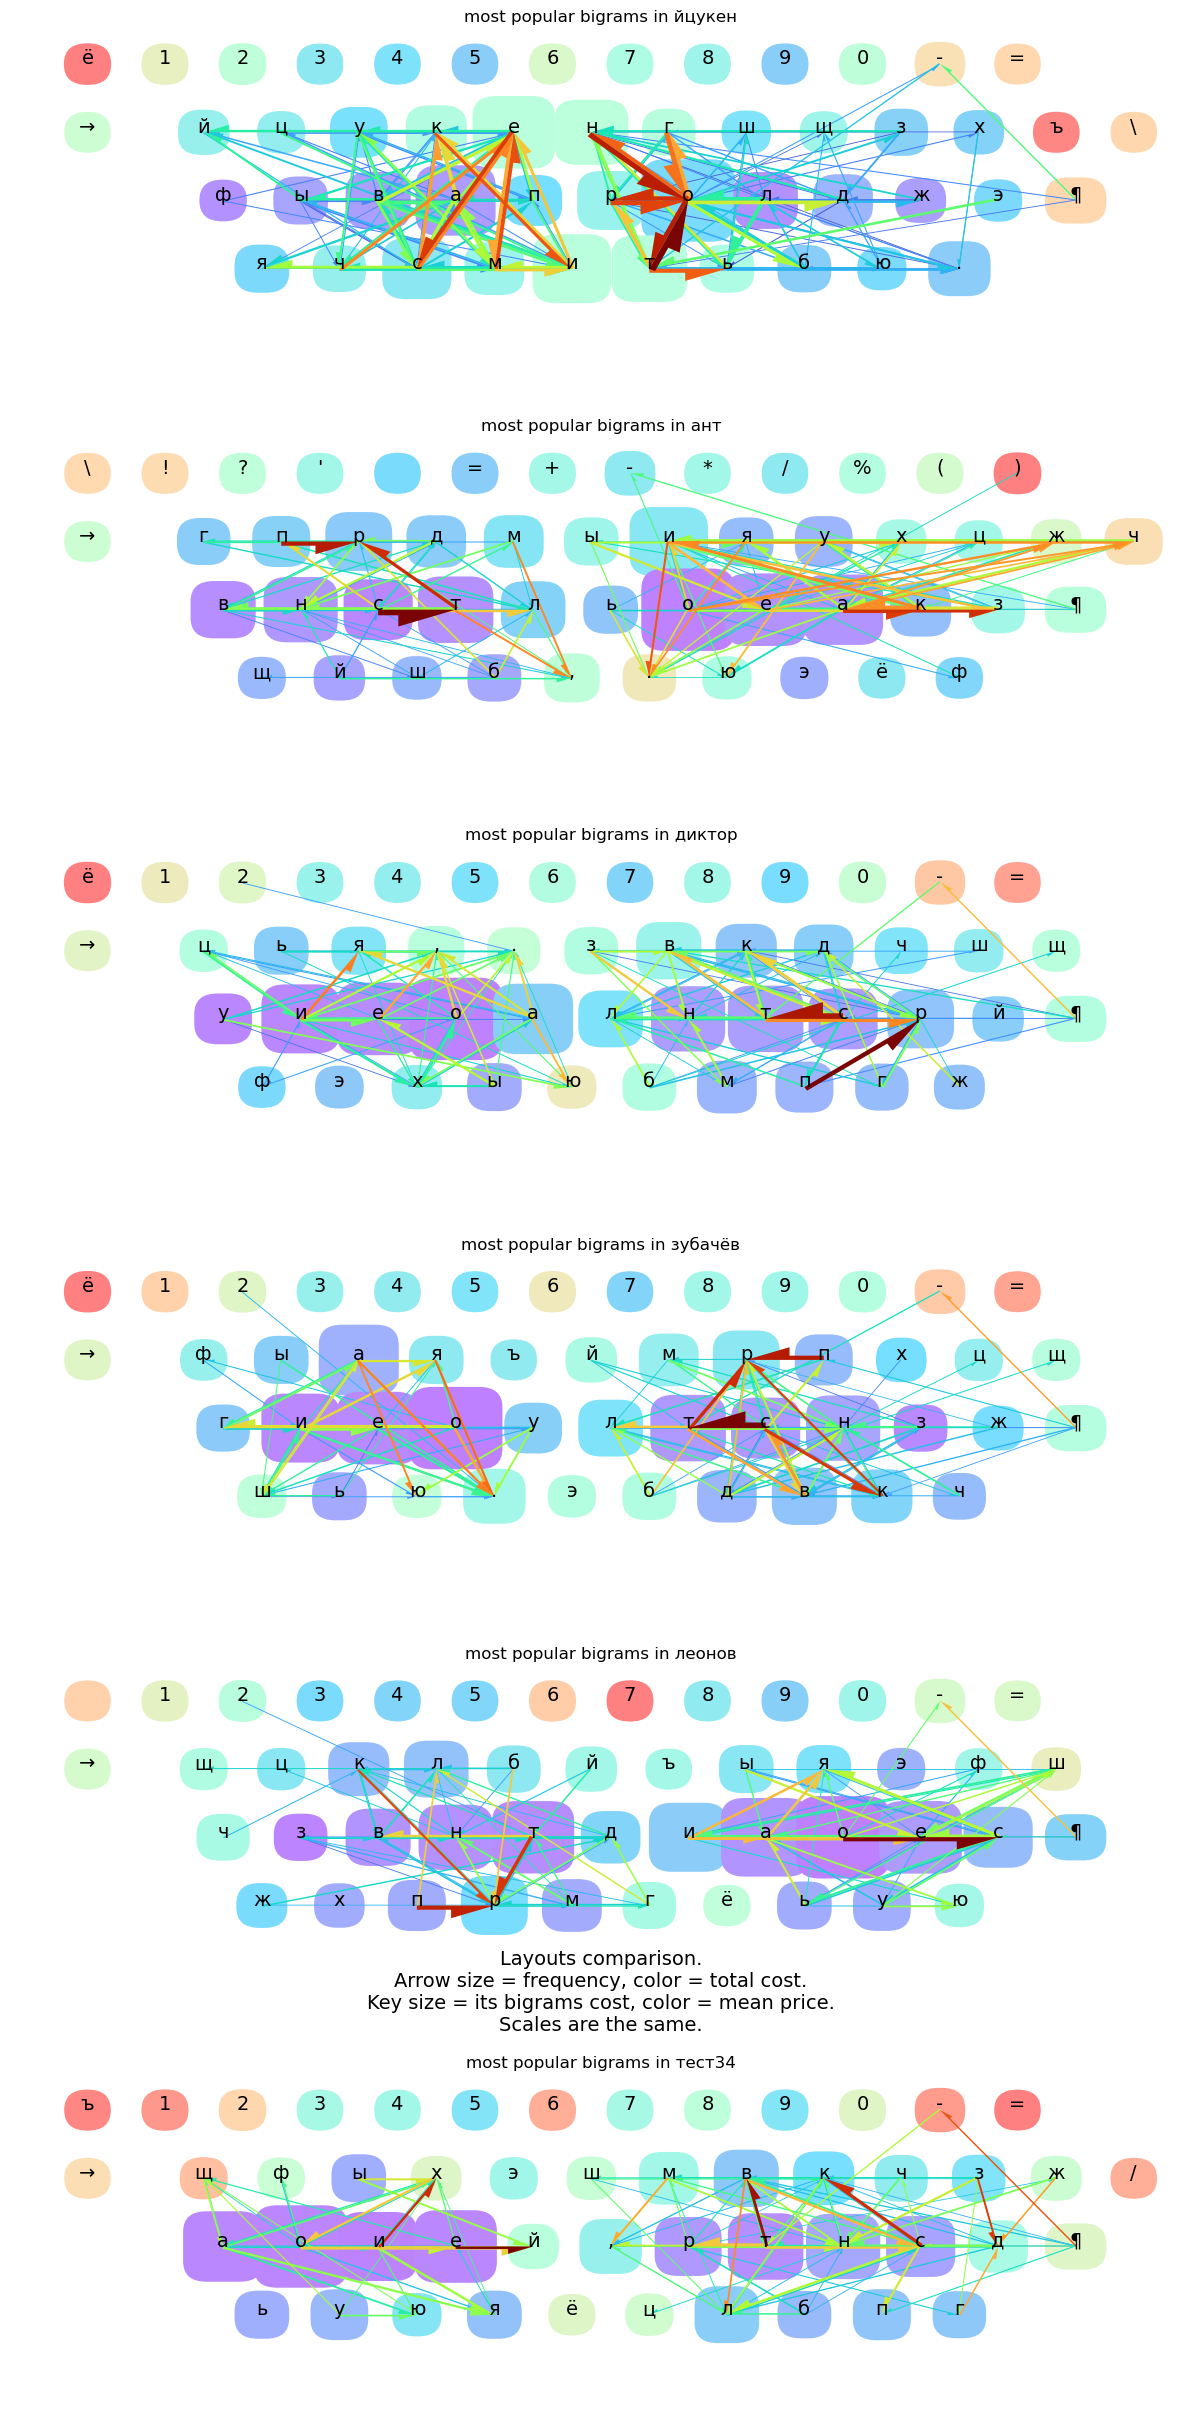

In [26]:
r = results
r['йцукен'].combomap(r['ант'], r['диктор'], r['зубачёв'], r['леонов'], r['тест34'])

# Heatmaps <a name="heatmaps">

To see the heatmap by just number of key presses, use `pivot_table('num'`, to see the one for penalties, use `pivot_table('cost'`.

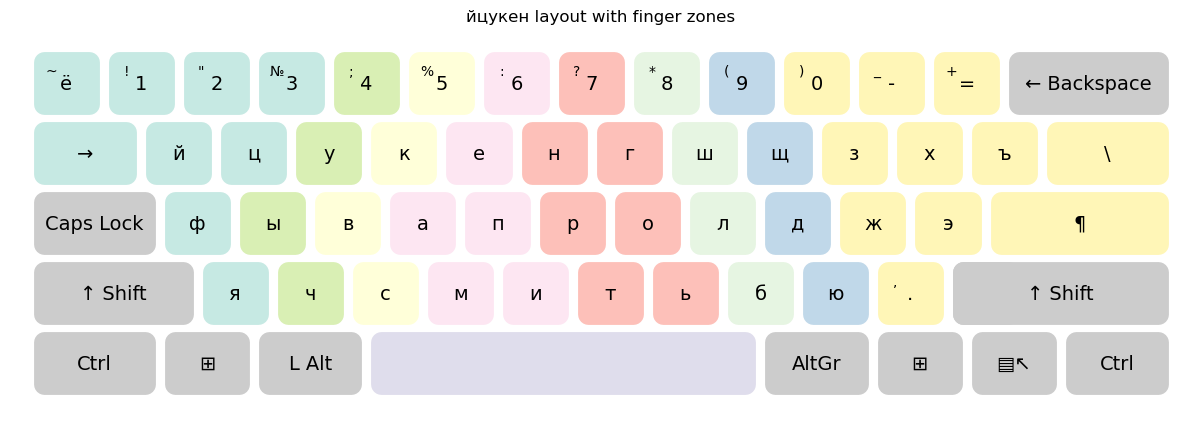

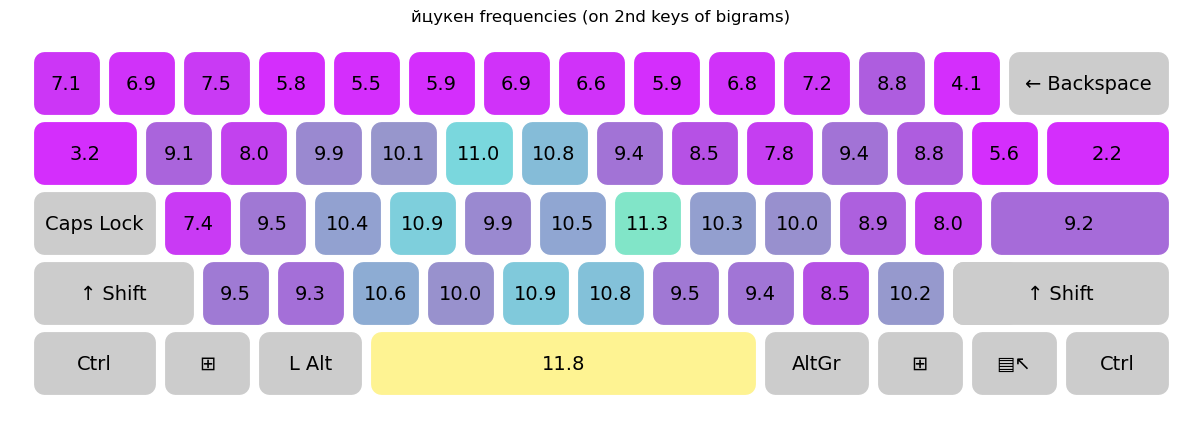

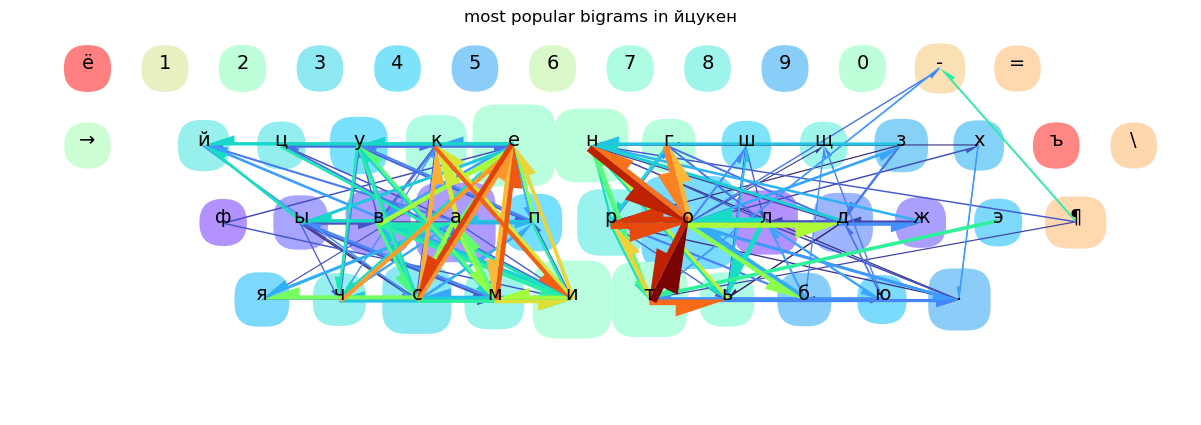

In [27]:
results['йцукен'].display('layout', 'num', 'arrows')

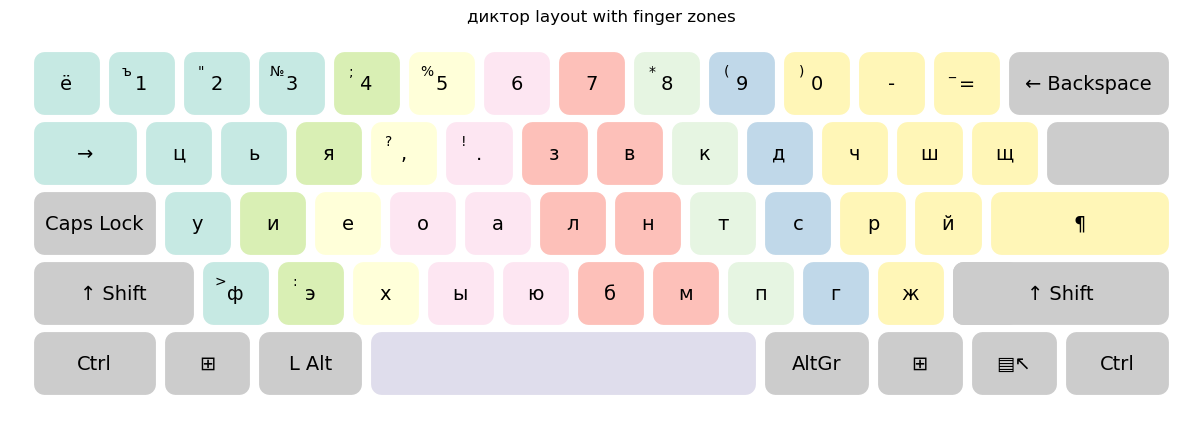

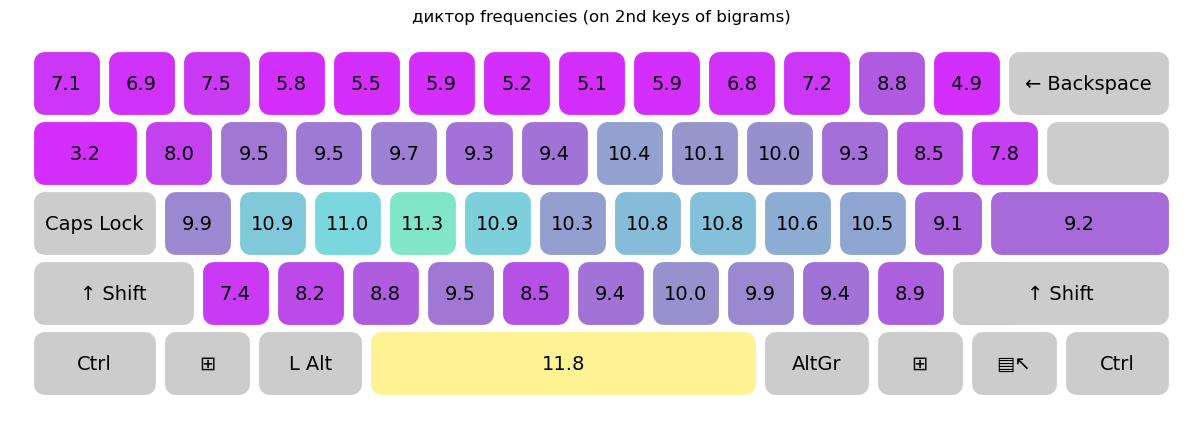

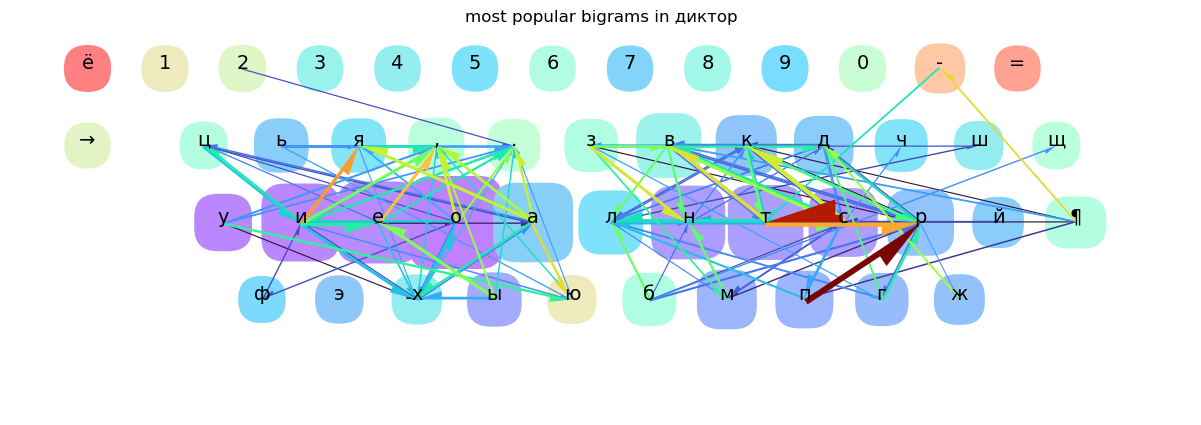

In [28]:
results['диктор'].display('layout', 'num', 'arrows')

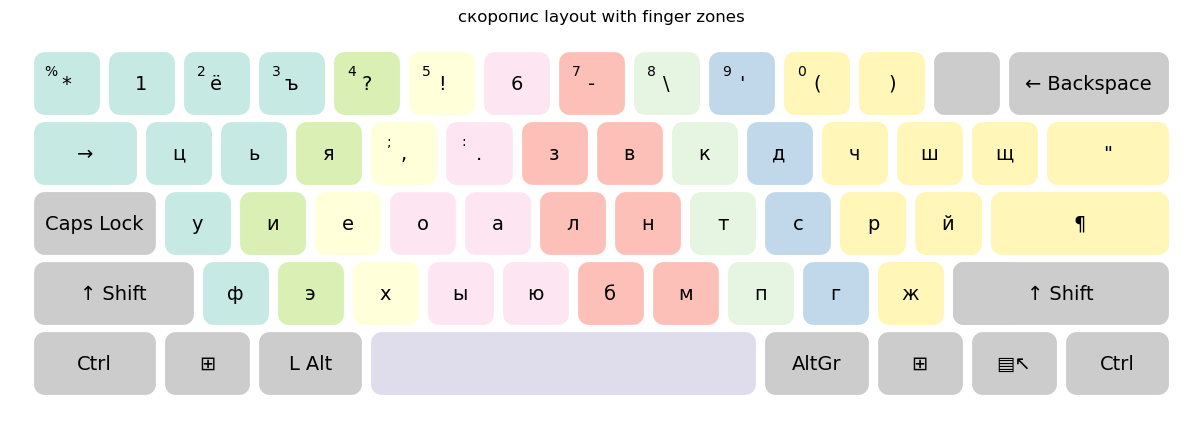

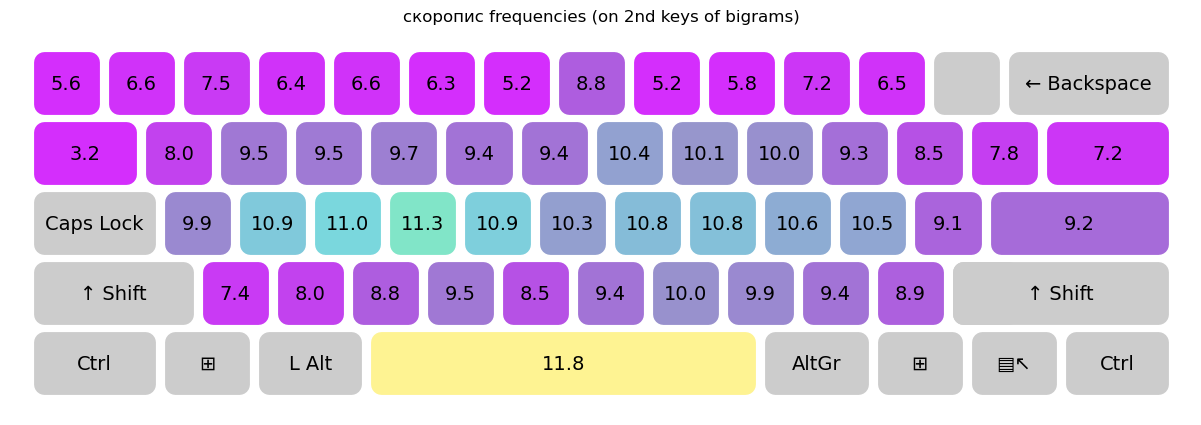

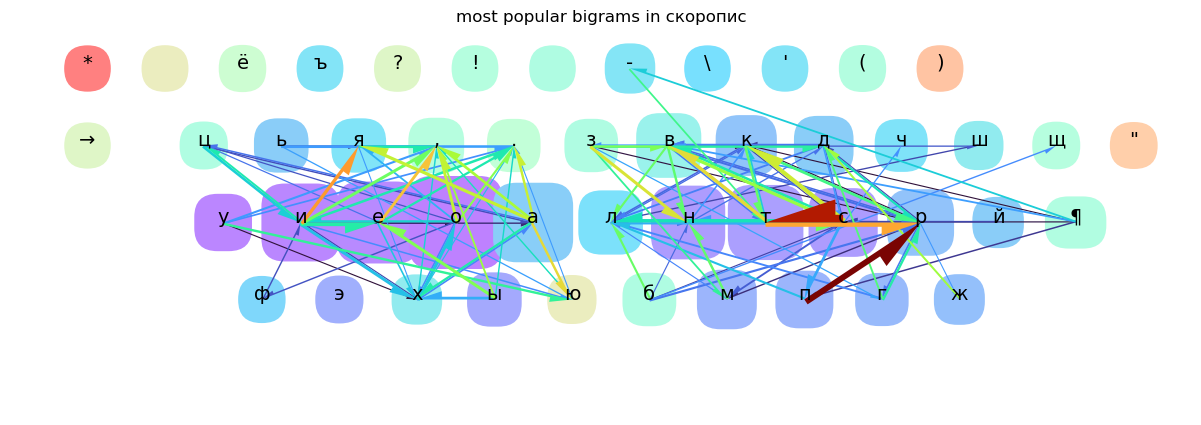

In [29]:
results['скоропис'].display('layout', 'num', 'arrows')

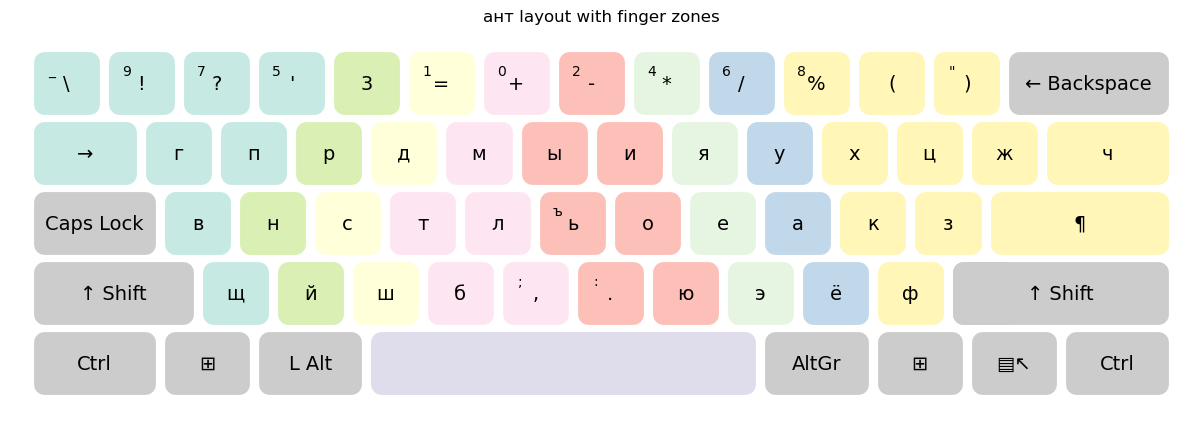

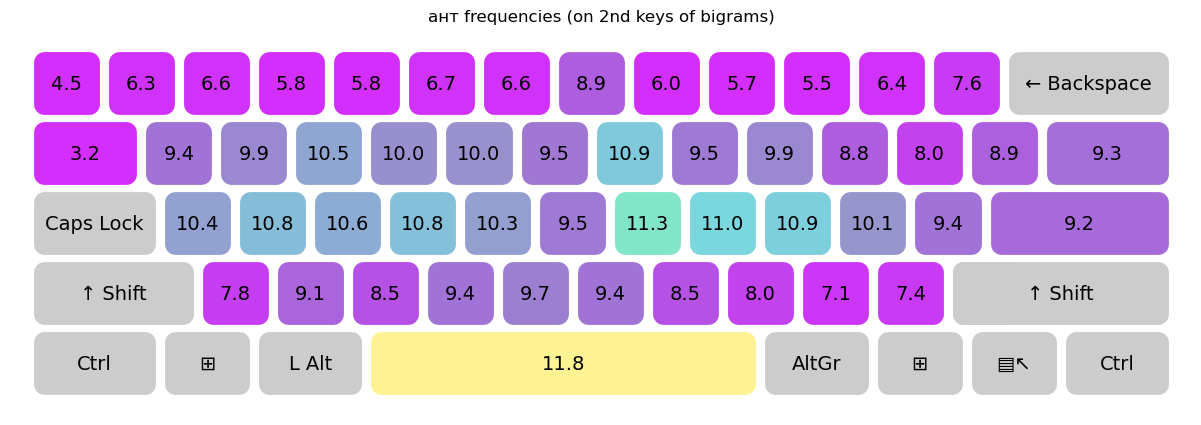

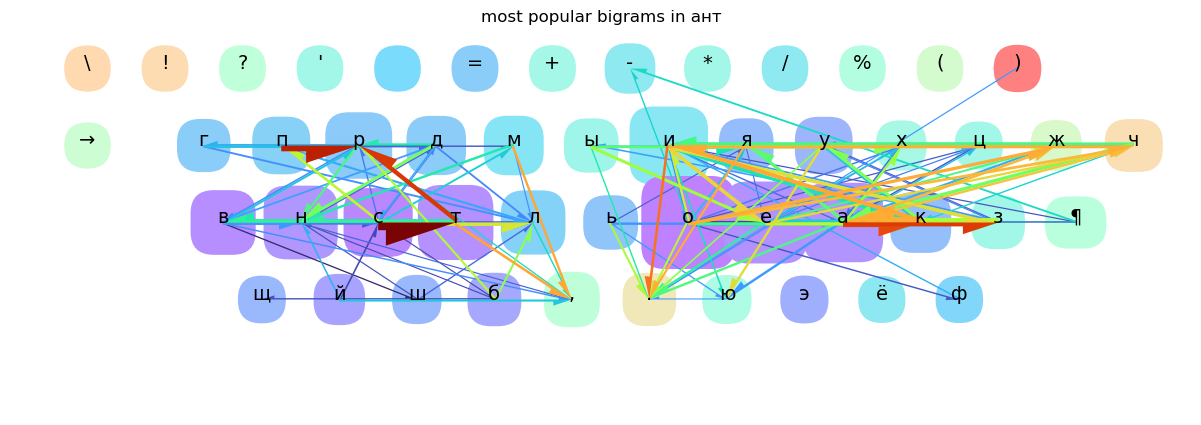

In [30]:
results['ант'].display('layout', 'num', 'arrows')

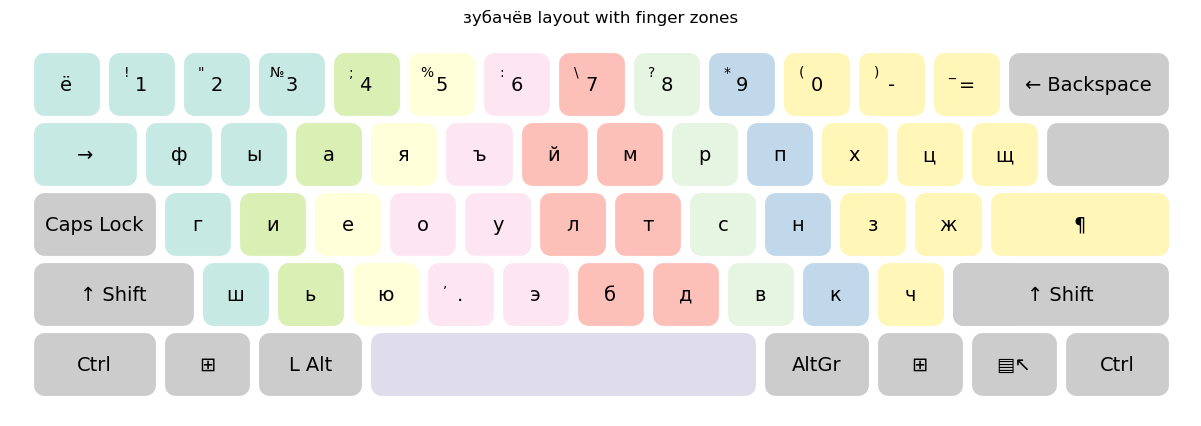

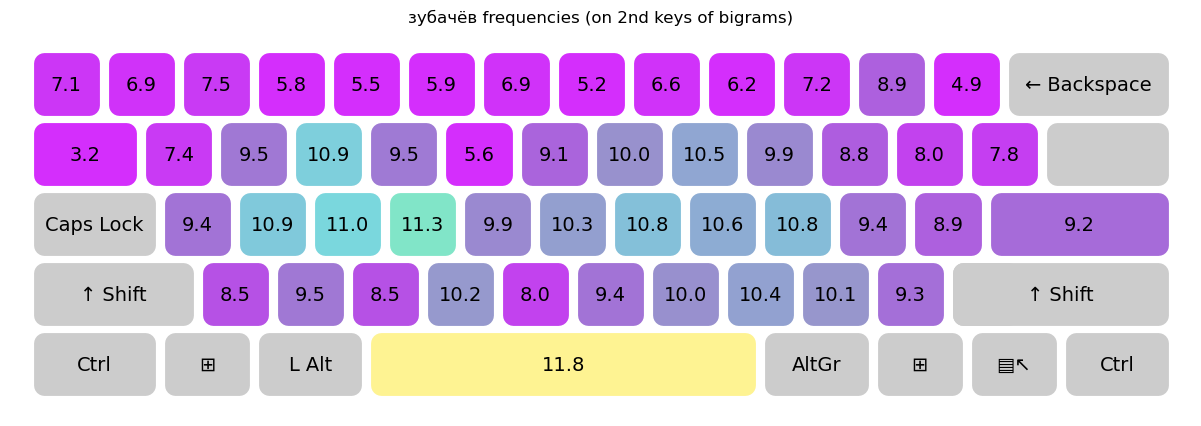

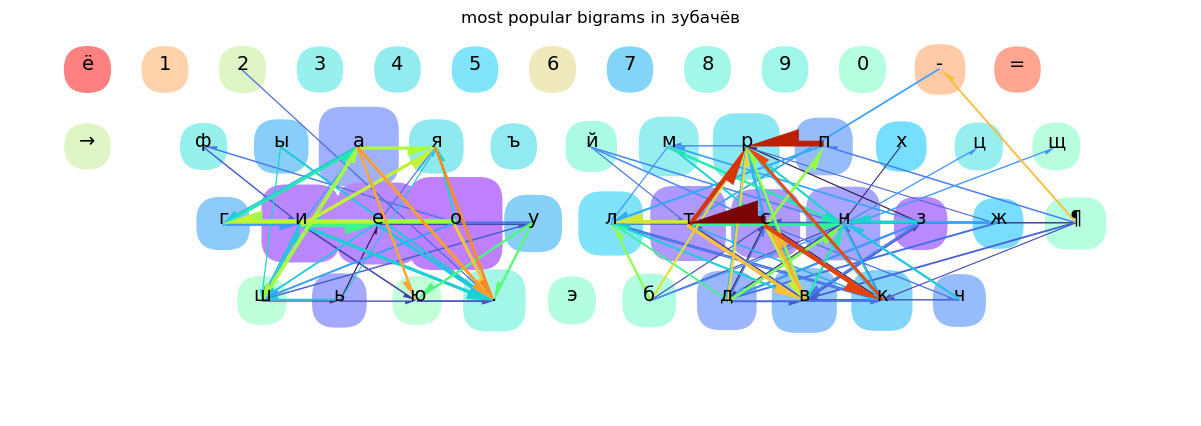

In [31]:
results['зубачёв'].display('layout', 'num', 'arrows')

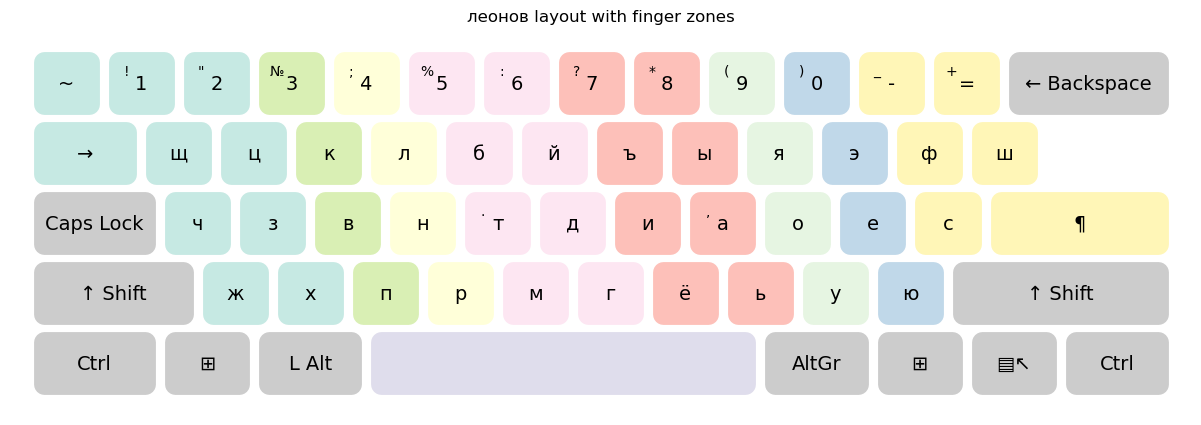

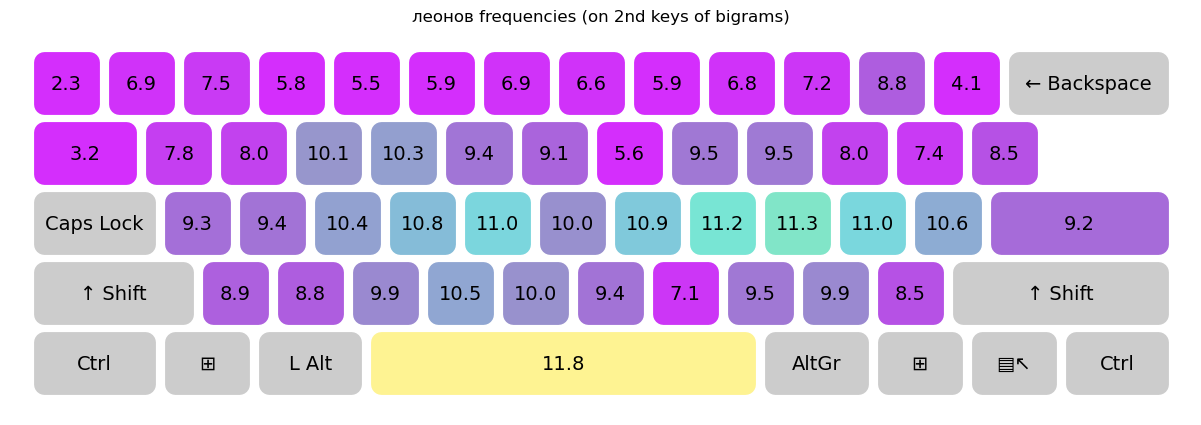

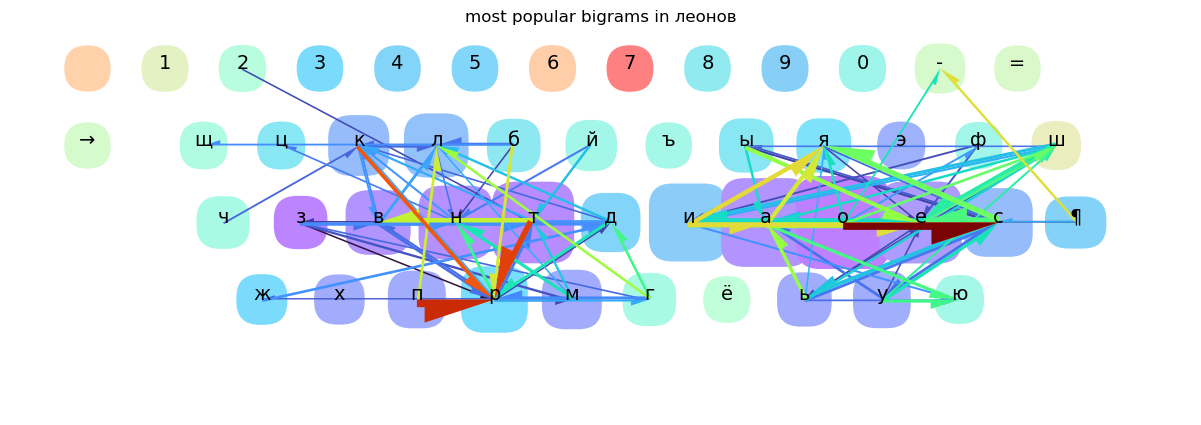

In [32]:
results['леонов'].display('layout', 'num', 'arrows')

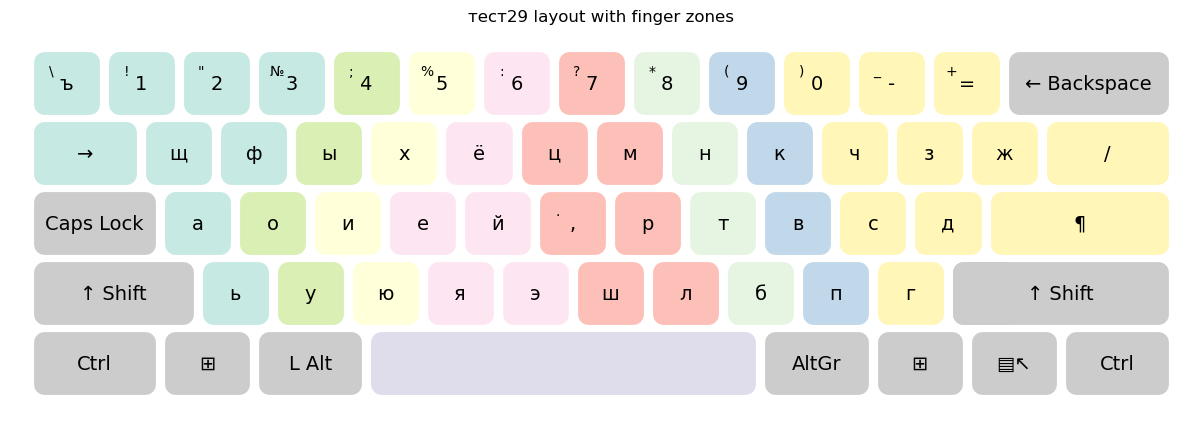

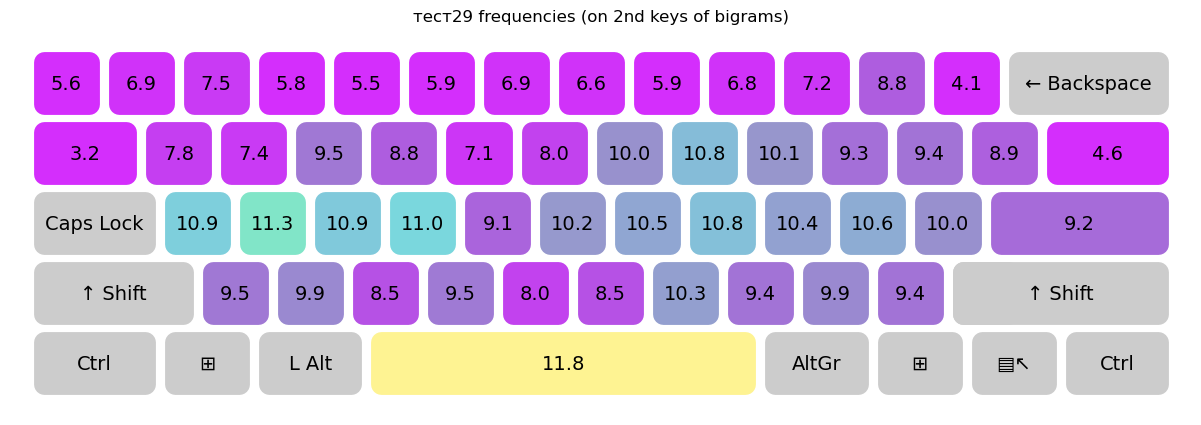

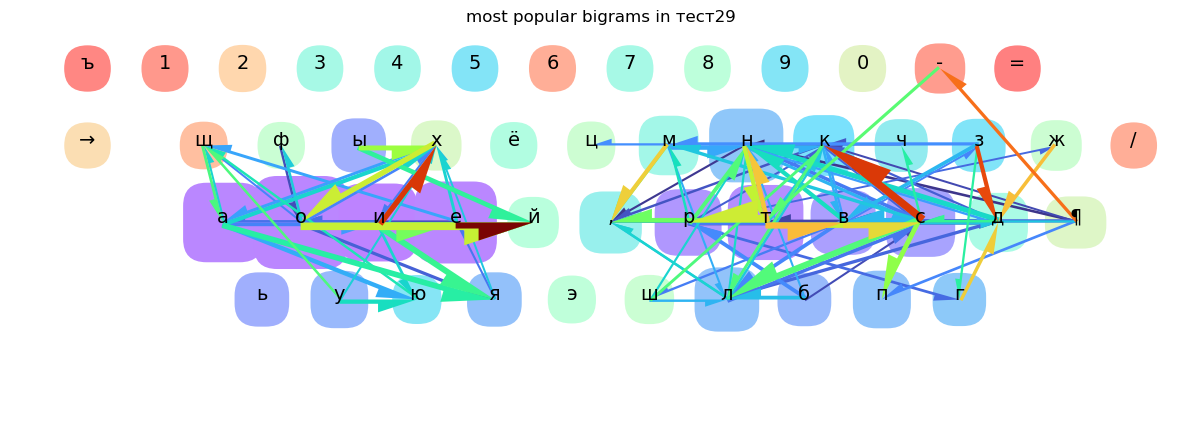

In [33]:
results['тест29'].display('layout', 'num', 'arrows')

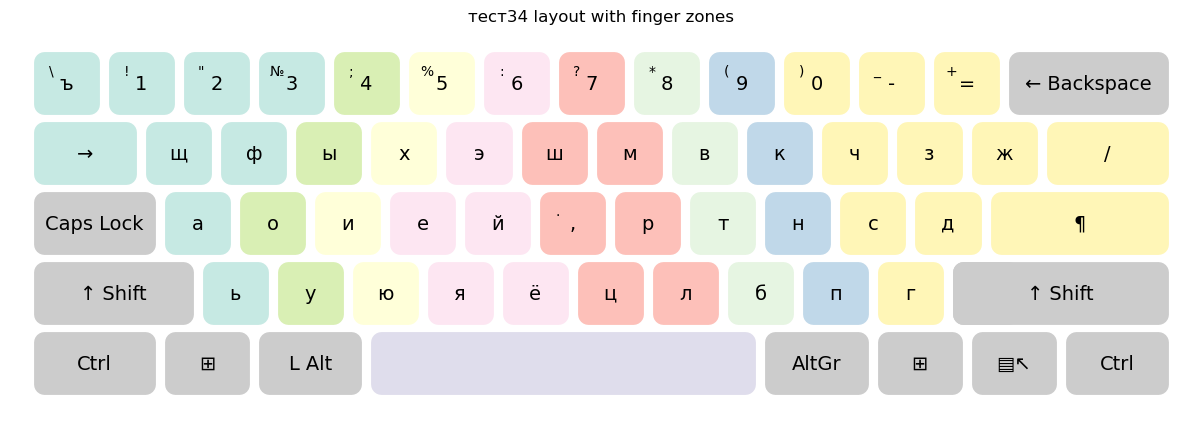

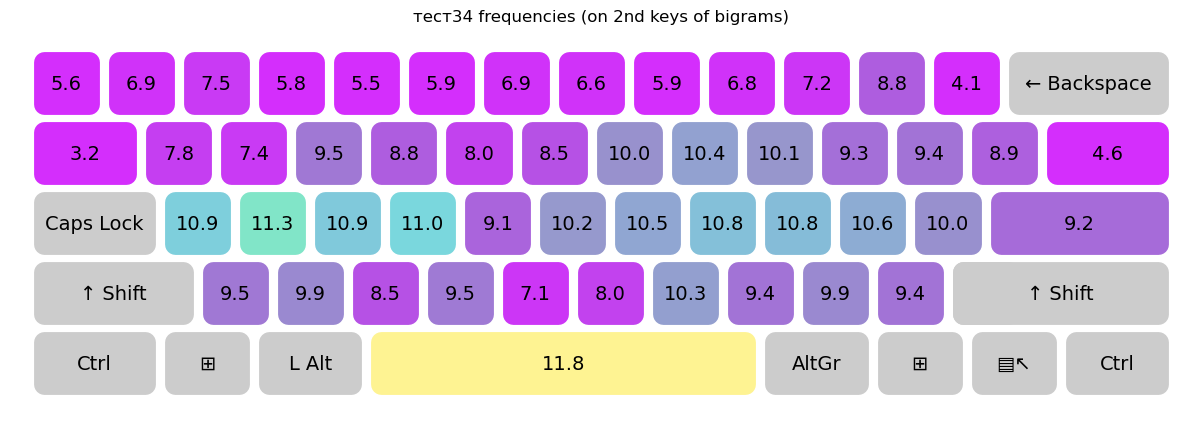

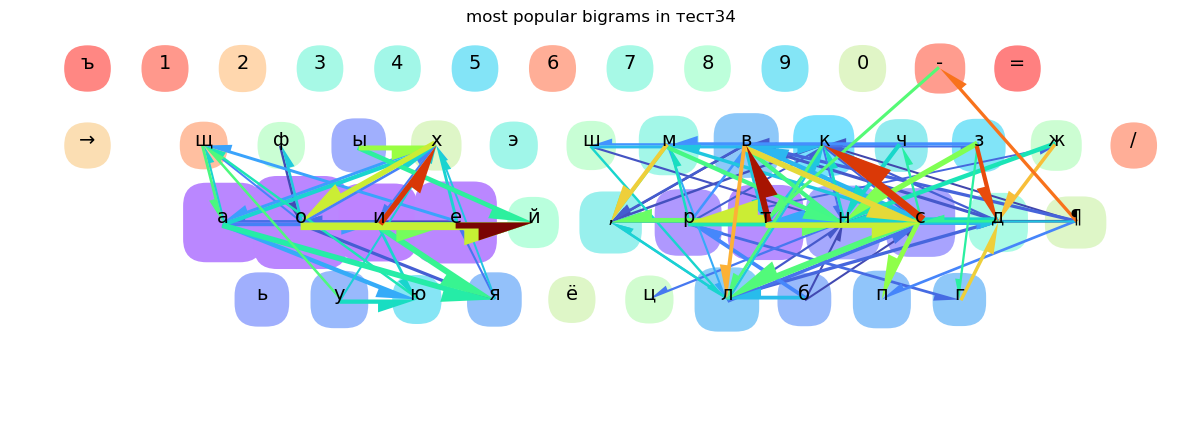

In [34]:
results['тест34'].display('layout', 'num', 'arrows')

# Comparison of best others' and mine

In [35]:
r = compare(results, 'леонов', 'тест32')
r.head(30)

bigram    num                     category_old  price_old  cost_old  \
55      по   7093                     altern hands          0         0   
177     .¶   3921                     altern hands          2      7842   
18      ⌴в  11347                        space bar          0         0   
303     па   1120                     altern hands          0         0   
194     хо   1638                     altern hands          0         0   
447     зд    979      in, over 1 finger, same row          2      1958   
53      ¶¶   4802                         same key          2      9604   
114     ск   3125                     altern hands          1      3125   
296     ей   2009                     altern hands          4      8036   
291     ап    735                     altern hands          1       735   
465     вс   1832                     altern hands          0         0   
182     ⌴э   2440                        space bar          1      2440   
94      ⌴з   3466                        space bar          0         0   
35      ов   6667                     altern hands          0         0   
130     тс   1614                     altern hands          0         0   
338     вл    794  in, adj finger, same or adj row          3      2382   
111     их   1574                     altern hands          1      1574   
49      тв   2081             out, over one finger          4      8324   
262     ия   1949             out, over one finger          5      9745   
295     оп   1156                     altern hands          1      1156   
38      ть   5581                     altern hands          1      5581   
116     аз   2695                     altern hands          0         0   
196     зн   1644      in, over 1 finger, same row          0         0   
179     т,   1153                     altern hands          0         0   
124     ⌴-   2268                        space bar          4      9072   
64      из   2251                     altern hands          0         0   
459     -т    542                     altern hands          0         0   
46      ль   4283                     altern hands          1      4283   
125     --   2097                         same key          4      8388   
498     зм    567       in, over 1 finger, adj row          2      1134   

                        category_new  price_new  cost_new  delta  
55           pinky -> ring, next row          3     21279  21279  
177                   index -> pinky          6     23526  15684  
18                         space bar          1     11347  11347  
303                    pinky adj row         10     11200  11200  
194              same finger adj row          6      9828   9828  
447                    pinky adj row         12     11748   9790  
53                          same key          4     19208   9604  
114          pinky -> ring, next row          4     12500   9375  
296              same finger adj row          8     16072   8036  
291                    pinky adj row         11      8085   7350  
465             out, over one finger          4      7328   7328  
182                        space bar          4      9760   7320  
94                         space bar          2      6932   6932  
35                      altern hands          1      6667   6667  
130             out, over one finger          4      6456   6456  
338              adj finger over row         11      8734   6352  
111             out, over one finger          5      7870   6296  
49               same finger adj row          7     14567   6243  
262              same finger adj row          8     15592   5847  
295          ring -> pinky, next row          6      6936   5780  
38                      altern hands          2     11162   5581  
116                     altern hands          2      5390   5390  
196          pinky -> ring, next row          3      4932   4932  
179  in, adj finger, same or adj row          4      4612   4612  
124

In [36]:
r.tail(30)

bigram   num                     category_old  price_old  cost_old  \
156     ис  2458                   index -> pinky          2      4916   
256     ые  1696             out, over one finger          4      6784   
404     се  2649  in, adj finger, same or adj row          2      5298   
190     а,  1328              same finger adj row          6      7968   
110     ки  2886                     altern hands          2      5772   
69      ор  5921                     altern hands          1      5921   
332     ег  1977                     altern hands          4      7908   
129     ае  1585             out, over one finger          4      6340   
300     и,  1600              same finger adj row          6      9600   
181     ой  3205                     altern hands          4     12820   
187     об  3213                     altern hands          3      9639   
491     гл   645              adj finger over row         11      7095   
238     ас  3302                   index -> pinky          2      6604   
184     ое  1887             out, over one finger          4      7548   
133     ⌴ч  3827                        space bar          4     15308   
33      ти  3904                     altern hands          2      7808   
252     пл   786              adj finger over row         11      8646   
324     бр   812              adj finger over row         11      8932   
28      ри  4244                     altern hands          2      8488   
225     ⌴б  4888                        space bar          3     14664   
78      тр  3288             out, over one finger          5     16440   
79      ⌴г  3298                        space bar          4     13192   
153     ог  3341                     altern hands          4     13364   
7       ли  5507                     altern hands          2     11014   
31      кр  1386              adj finger over row         11     15246   
15      ни  7156                     altern hands          2     14312   
61      ес  4129             out, over one finger          4     16516   
41      пр  6010  in, adj finger, same or adj row          3     18030   
23      ⌴и  9284                        space bar          2     18568   
56      ос  5489             out, over one finger          4     21956   

                        category_new  price_new  cost_new  delta  
156                     altern hands          0         0  -4916  
256       in, over 1 finger, adj row          1      1696  -5088  
404                     altern hands          0         0  -5298  
190                     altern hands          2      2656  -5312  
110                     altern hands          0         0  -5772  
69                      altern hands          0         0  -5921  
332                     altern hands          1      1977  -5931  
129      in, over 1 finger, same row          0         0  -6340  
300                     altern hands          2      3200  -6400  
181      in, over 1 finger, same row          2      6410  -6410  
187                     altern hands          1      3213  -6426  
491      in, over 1 finger, same row          1       645  -6450  
238                     altern hands          0         0  -6604  
184      in, over 1 finger, same row          0         0  -7548  
133                        space bar          2      7654  -7654  
33                      altern hands          0         0  -7808  
252                     altern hands          1       786  -7860  
324       in, over 1 finger, adj row          1       812  -8120  
28                      altern hands          0         0  -8488  
225                        space bar          1      4888  -9776  
78   in, adj finger, same or adj row          2      6576  -9864  
79                         space bar          1      3298  -9894  
153                     altern hands          1      3341 -10023  
7                       altern hands          0         0 -11014  
31        in, over 1 finger, adj r

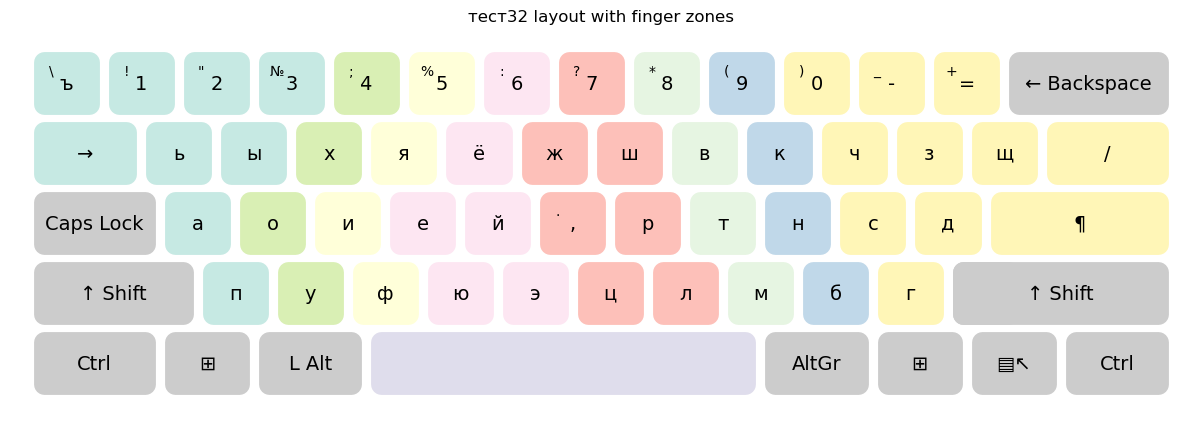

In [37]:
results['тест32'].layout.display()

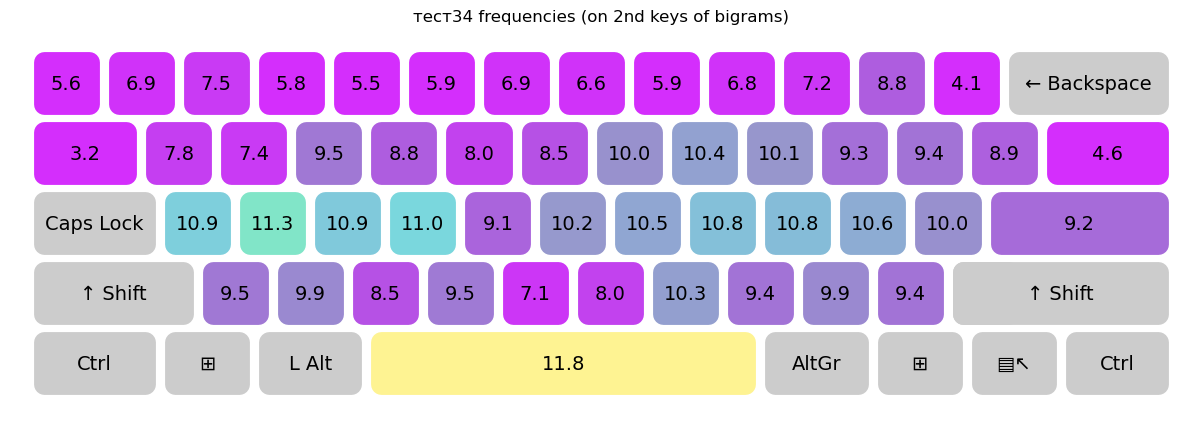

In [38]:
results['тест34'].display('nums')

<AxesSubplot: xlabel='finger'>

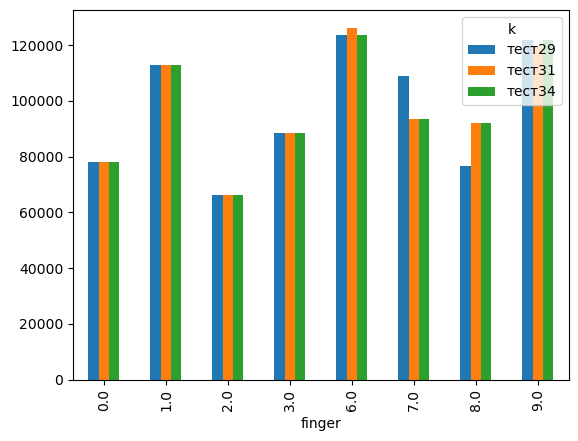

In [39]:
dfs = []
for k in ('тест29', 'тест31', 'тест34'):
    d = results[k].bigrams
    d = d[d.finger != 4].groupby('finger').agg({'num': 'sum'})
    d['k'] = k
    dfs.append(d)
x = pd.concat(dfs)

x.pivot_table('num', 'k', 'finger').T.plot.bar()

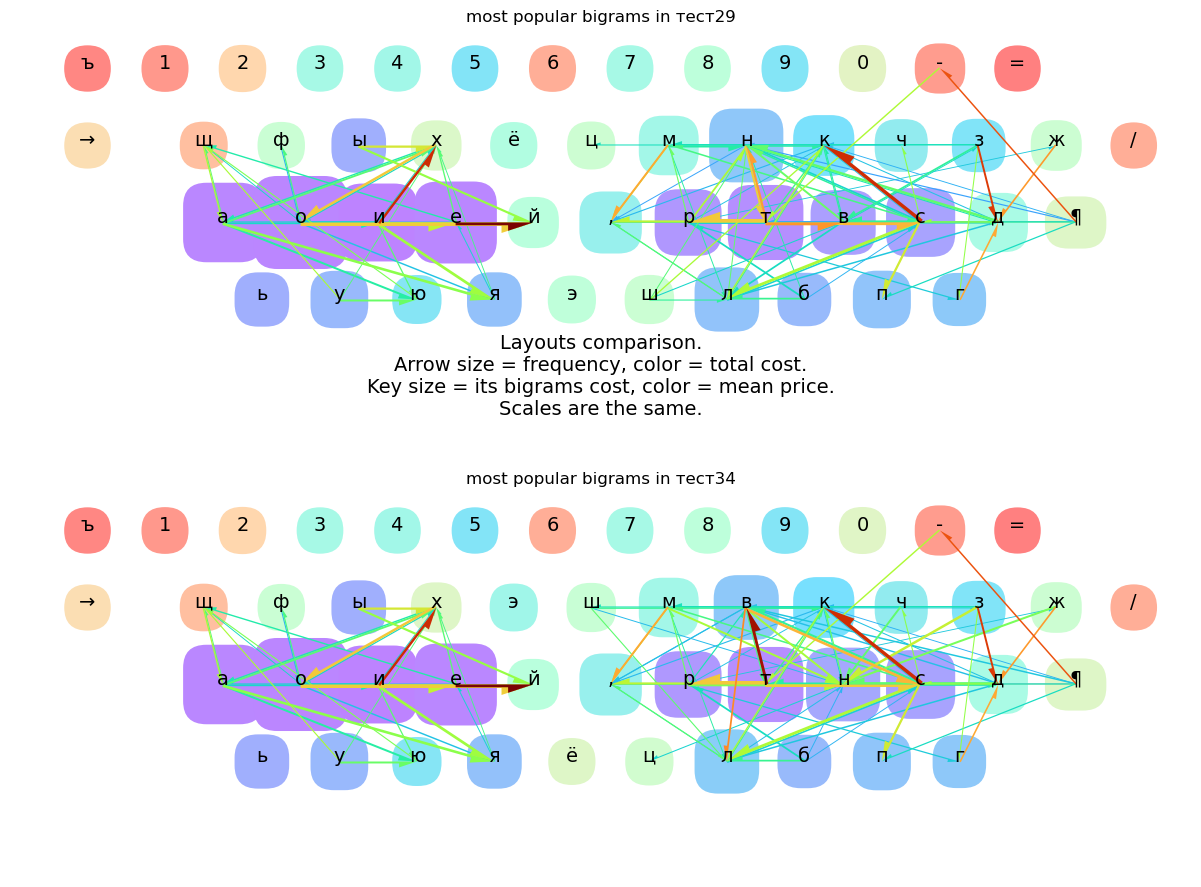

In [40]:
results['тест29'].combomap(results['тест34'])

In [41]:
results['тест37'].layout.export()


	default partial alphanumeric_keys
	xkb_symbols "v37" {
		include "ru(common)"
		name[Group1]= "Culebron (тест37)";
			key <TLDE> { [ Cyrillic_hardsign, Cyrillic_HARDSIGN, backslash ] };
	key <AE01> { [ 1, exclam ] };
	key <AE02> { [ 2, quotedbl ] };
	key <AE03> { [ 3, numerosign ] };
	key <AE04> { [ 4, semicolon ] };
	key <AE05> { [ 5, percent ] };
	key <AE06> { [ 6, colon ] };
	key <AE07> { [ 7, question ] };
	key <AE08> { [ 8, asterisk ] };
	key <AE09> { [ 9, parenleft ] };
	key <AE10> { [ 0, parenright ] };
	key <AE11> { [ minus, underscore ] };
	key <AE12> { [ equal, plus ] };
	key <AD01> { [ Cyrillic_ef, Cyrillic_EF ] };
	key <AD02> { [ Cyrillic_tse, Cyrillic_TSE ] };
	key <AD03> { [ Cyrillic_yeru, Cyrillic_YERU ] };
	key <AD04> { [ Cyrillic_ha, Cyrillic_HA ] };
	key <AD05> { [ Cyrillic_io, Cyrillic_IO ] };
	key <AD06> { [ Cyrillic_sha, Cyrillic_SHA ] };
	key <AD07> { [ Cyrillic_em, Cyrillic_EM ] };
	key <AD08> { [ Cyrillic_ve, Cyrillic_VE ] };
	key <AD09> { [ Cyrillic_ka, Cyril